# Prédiction du niveau calorique des recettes avec apprentissage automatique

## XGBoost V2
Ce notebook utilise un classifieur pour prédire le niveau calorique des recettes (BAS/MOYEN/HAUT) basé sur les ingrédients et instructions, avec préprocessing NLP, XGBoost et interprétation SHAP.

Des optimisations NLP, ngrammes et nb features du TF-IDF

## Objectifs:
- Classifier les recettes en 3 niveaux caloriques (bas < 250, moyen 250-500, haut > 500)
- Utiliser Random Forest vs. XGBoost avec bonnes pratiques
- Préprocessing NLP des ingrédients et instructions
- Interprétation avec SHAP (explicabilité très importante dans la nutrition)

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.sparse import hstack, csr_matrix
from collections import Counter
import shap
import re
import ast
import warnings
warnings.filterwarnings('ignore')

# Thème sombre
plt.style.use('dark_background')
plt.rcParams['axes.unicode_minus'] = False

# Palette de couleurs
colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', '#FF9FF3', '#54A0FF', '#5F27CD', '#A8E6CF', '#FFD93D']

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries importées avec succès!")

Libraries importées avec succès!


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Chargement et exploration rapide des données

In [2]:
# Chargement des données
df = pd.read_csv('data/RAW_recipes.csv')
print(f"Forme du dataset: {df.shape}")
print(f"\nColonnes: {df.columns.tolist()}")
print(f"\nPremières lignes:")
df.head()
# Informations sur le dataset
df.info()
print("\nValeurs manquantes:")
print(df.isnull().sum())

Forme du dataset: (231637, 12)

Colonnes: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']

Premières lignes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231637 entries, 0 to 231636
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   name            231636 non-null  object
 1   id              231637 non-null  int64 
 2   minutes         231637 non-null  int64 
 3   contributor_id  231637 non-null  int64 
 4   submitted       231637 non-null  object
 5   tags            231637 non-null  object
 6   nutrition       231637 non-null  object
 7   n_steps         231637 non-null  int64 
 8   steps           231637 non-null  object
 9   description     226658 non-null  object
 10  ingredients     231637 non-null  object
 11  n_ingredients   231637 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 21.2+ MB

V

## 3. Préprocessing des données nutritionnelles

In [3]:
def parse_nutrition(nutrition_str):
    """Parse la colonne nutrition pour extraire les valeurs nutritionnelles"""
    try:
        # Convertir la chaîne en liste
        nutrition_list = ast.literal_eval(nutrition_str)
        return nutrition_list
    except:
        return [0, 0, 0, 0, 0, 0, 0]

# Appliquer le parsing
df['nutrition_parsed'] = df['nutrition'].apply(parse_nutrition)

# Extraire les valeurs nutritionnelles (l'ordre est: calories, total_fat, sugar, sodium, protein, saturated_fat, carbohydrates)
nutrition_columns = ['calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat', 'carbohydrates']
for i, col in enumerate(nutrition_columns):
    df[col] = df['nutrition_parsed'].apply(lambda x: x[i] if len(x) > i else 0)

# Supprimer les valeurs aberrantes de calories (> 3000 ou < 0)
df = df[(df['calories'] >= 0) & (df['calories'] <= 3000)]

print(f"Statistiques des calories après nettoyage:")
print(df['calories'].describe())

Statistiques des calories après nettoyage:
count    228486.000000
mean        408.524812
std         384.645804
min           0.000000
25%         172.600000
50%         309.100000
75%         507.900000
max        2999.800000
Name: calories, dtype: float64


## 4. Analyse descriptive des calories


Seuil bas: 0-215, Seuil moyen: 215-430, Seuil haut: 430-3000


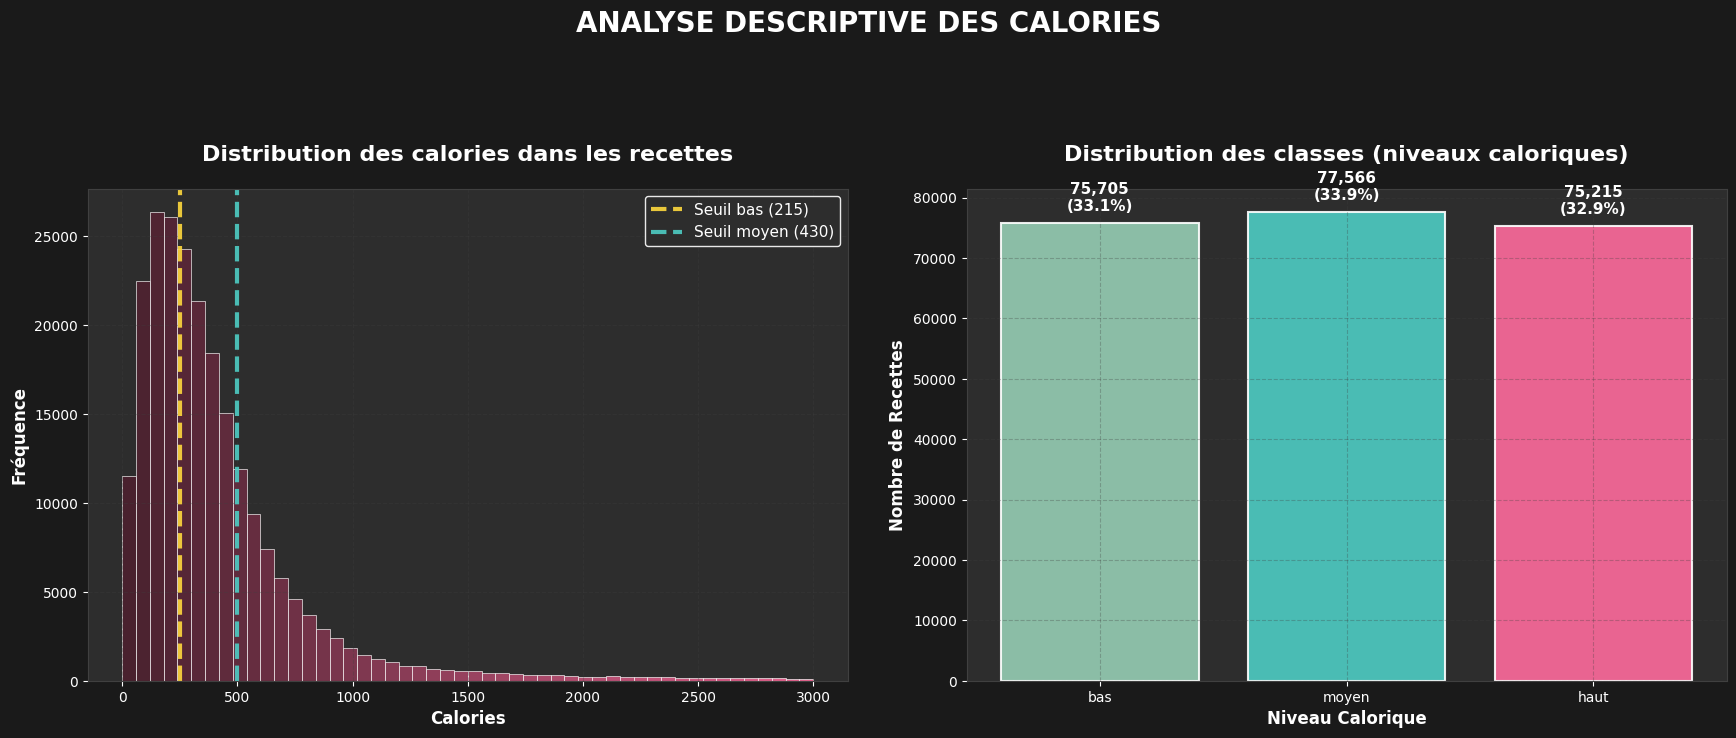

Distribution des niveaux caloriques:
calorie_level
moyen    77566
bas      75705
haut     75215
Name: count, dtype: int64

Pourcentages:
calorie_level
moyen    33.947813
bas      33.133321
haut     32.918866
Name: proportion, dtype: float64


In [ ]:
# arrondir au supérieur
seuil_33 = int(df['calories'].quantile(0.33)) + 1
seuil_67 = int(df['calories'].quantile(0.67)) + 1

# seuils bas, moyen, haut (variable cible)
print(f"Seuil bas: 0-{seuil_33}, Seuil moyen: {seuil_33}-{seuil_67}, Seuil haut: {seuil_67}-{3000}")

def classify_calories_by_percentile(cal):
    if cal < seuil_33:
        return 'bas'
    elif cal <= seuil_67:
        return 'moyen'
    else:
        return 'haut'

# Recalculer avec des classes équilibrées (33.33% chacune)
df['calorie_level'] = df['calories'].apply(
    lambda x: classify_calories_by_percentile(x)
)
    
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.patch.set_facecolor('#1a1a1a')

# Distribution des calories
axes[0].set_facecolor('#2d2d2d')
n, bins, patches = axes[0].hist(df['calories'], bins=50, alpha=0.9, 
                               edgecolor='white', linewidth=0.5)


for i, patch in enumerate(patches):
    base_color = np.array([255, 107, 157])  # #FF6B9D en RGB
    intensity = 0.3 + 0.7 * (i / len(patches))
    color = base_color * intensity / 255.0
    patch.set_facecolor(color)

axes[0].set_title('Distribution des calories dans les recettes', fontweight='bold', 
                 fontsize=16, color='white', pad=20)
axes[0].set_xlabel('Calories', fontweight='bold', color='white', fontsize=12)
axes[0].set_ylabel('Fréquence', fontweight='bold', color='white', fontsize=12)

# Lignes de seuil avec couleurs contrastantes
axes[0].axvline(x=250, color='#FFD93D', linestyle='--', linewidth=3, 
               alpha=0.9, label=f'Seuil bas ({seuil_33})')
axes[0].axvline(x=500, color='#4ECDC4', linestyle='--', linewidth=3, 
               alpha=0.9, label=f'Seuil moyen ({seuil_67})')

axes[0].tick_params(colors='white')
axes[0].grid(True, alpha=0.3, color='#404040', linestyle='--')

# Légende
legend = axes[0].legend(framealpha=0.9, facecolor='#2d2d2d', 
                       edgecolor='white', fontsize=11)
for text in legend.get_texts():
    text.set_color('white')

for spine in axes[0].spines.values():
    spine.set_color('#404040')

# Distribution des niveaux caloriques
axes[1].set_facecolor('#2d2d2d')

calorie_counts = df['calorie_level'].value_counts()

ordered_levels = ['bas', 'moyen', 'haut']
ordered_counts = [calorie_counts.get(level, 0) for level in ordered_levels]

level_colors = ['#96CEB4', '#4ECDC4', '#FF6B9D']  # Vert, Cyan, Rose

bars = axes[1].bar(ordered_levels, ordered_counts, 
                   color=level_colors, alpha=0.9, 
                   edgecolor='white', linewidth=1.5)

axes[1].set_title('Distribution des classes (niveaux caloriques)', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
axes[1].set_xlabel('Niveau Calorique', fontweight='bold', color='white', fontsize=12)
axes[1].set_ylabel('Nombre de Recettes', fontweight='bold', color='white', fontsize=12)

for i, (bar, count) in enumerate(zip(bars, ordered_counts)):
    percentage = (count / sum(ordered_counts)) * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, 
                bar.get_height() + max(ordered_counts)*0.02,
                f'{count:,}\n({percentage:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', 
                color='white', fontsize=11)

axes[1].tick_params(colors='white')
axes[1].grid(True, alpha=0.3, color='#404040', linestyle='--')

for spine in axes[1].spines.values():
    spine.set_color('#404040')

fig.suptitle('ANALYSE DESCRIPTIVE DES CALORIES', 
             fontsize=20, fontweight='bold', color='white', y=0.98)

plt.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
plt.show()

print("Distribution des niveaux caloriques:")
print(df['calorie_level'].value_counts())
print("\nPourcentages:")
print(df['calorie_level'].value_counts(normalize=True) * 100)


## 5. Préprocessing NLP des ingrédients et instructions

In [5]:
def clean_text(text):
    """Nettoyage"""
    if pd.isna(text):
        return ""
    
    text = str(text).lower()
    
    # Supprimer crochets et guillemets
    text = re.sub(r"[\[\]'\"]", "", text)
    # Remplacer virgules par #
    text = re.sub(r',\s*', '#', text)
    # Garder les ingrédients composés avec _ ex: olive oil = olive_oil
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r'\s+', '_', text)
    # Remettre espace à la place de #
    text = re.sub(r'#\s*', ' ', text)
    # Supprimer caractères spéciaux (sauf _)
    text = re.sub(r"[^a-zA-Z0-9_\s]", "", text)
    
    return text.strip()

def sort_ingredients(ingredients_text):
    """
    Trie les ingrédients par ordre alphabétique avant nettoyage
    """
    try:
        # Convertir la chaîne en liste
        ingredients_list = ast.literal_eval(ingredients_text)
        # Trier par ordre alphabétique
        sorted_ingredients = sorted(ingredients_list)
        # Retourner comme chaîne
        return str(sorted_ingredients)
    except:
        # Si échec, retourner tel quel
        return ingredients_text

# Test de la fonction de nettoyage
test_ingredient = "['chopped fresh spinach', 'tomato', 'olive oil', 'butter']"
print(f"\nTest de la fonction optimisée:")
print(f"Avant: {test_ingredient}")
print(f"Après: {clean_text(test_ingredient)}")

# Trier et nettoyer les ingrédients
print(f"\nTri et nettoyage des ingrédients en cours...")
df['ingredients_sorted'] = df['ingredients'].apply(sort_ingredients)
df['ingredients_cleaned'] = df['ingredients_sorted'].apply(clean_text)

# Supprimer les recettes avec du texte vide
df = df[df['ingredients_cleaned'].str.len() > 10]

print(f"Nombre de recettes après nettoyage avancé: {len(df)}")
print("\nExemple de texte nettoyé et optimisé:")
print(df['ingredients_cleaned'].iloc[0][:200] + "...")

# Statistiques d'amélioration
print(f"\nStatistiques d'amélioration:")
word_counts = df['ingredients_cleaned'].apply(lambda x: len(x.split()))
print(f"Nombre moyen de mots par recette: {word_counts.mean():.1f}")
print(f"Nombre médian de mots par recette: {word_counts.median():.1f}")
print(f"Recettes avec moins de 5 mots: {(word_counts < 5).sum():,}")
print(f"Recettes avec 5-15 mots: {((word_counts >= 5) & (word_counts <= 15)).sum():,}")
print(f"Recettes avec plus de 15 mots: {(word_counts > 15).sum():,}")



Test de la fonction optimisée:
Avant: ['chopped fresh spinach', 'tomato', 'olive oil', 'butter']
Après: chopped_fresh_spinach tomato olive_oil butter

Tri et nettoyage des ingrédients en cours...
Nombre de recettes après nettoyage avancé: 228430

Exemple de texte nettoyé et optimisé:
butter honey mexican_seasoning mixed_spice olive_oil salt winter_squash...

Statistiques d'amélioration:
Nombre moyen de mots par recette: 9.1
Nombre médian de mots par recette: 9.0
Recettes avec moins de 5 mots: 21,187
Recettes avec 5-15 mots: 194,500
Recettes avec plus de 15 mots: 12,743


## 6. Extraction de features

In [ ]:
protein_ingredients = {
    # Viandes (toutes les variantes seront normalisées automatiquement)
    'chicken', 'beef', 'turkey', 'pork', 'lamb', 'sausage', 'ham', 'bacon',
    
    # Poissons et fruits de mer
    'salmon', 'tuna', 'shrimp', 'crab', 'fish', 'scallops', 'anchovies',
    
    # Autres protéines
    'egg', 'tofu', 'beans', 'lentils',
    
    # Spécifiques qui restent
    'soybeans', 'tempeh'
}

vegetable_ingredients = {
    # Légumes de base (toutes variantes normalisées automatiquement)
    'onion', 'garlic', 'carrot', 'potato', 'celery', 'bell_pepper', 
    'mushroom', 'tomato', 'spinach', 'lettuce', 'cucumber', 'green_onion',
    
    # Légumes verts
    'broccoli', 'cauliflower', 'asparagus', 'green_beans', 'cabbage',
    
    # Courges et autres
    'zucchini', 'eggplant', 'squash', 'corn', 'peas',
    
    # Légumes spécialisés qui restent distincts
    'leek', 'shallot', 'kale', 'arugula', 'bok_choy', 'radishes', 
    'beets', 'parsnips', 'water_chestnuts', 'bean_sprouts'
}

spice_ingredients = {
    # Épices de base (toutes variantes normalisées)
    'salt', 'pepper', 'paprika', 'cumin', 'coriander', 'cinnamon', 
    'ginger', 'nutmeg', 'cloves', 'cardamom', 'turmeric', 'allspice',
    
    # Herbes (toutes variantes normalisées)
    'oregano', 'thyme', 'rosemary', 'basil', 'parsley', 'sage', 
    'dill', 'mint', 'marjoram', 'tarragon', 'cilantro', 'chives',
    
    # Piments et épices fortes
    'cayenne', 'cayenne_pepper', 'red_pepper_flakes', 'chilies', 
    'jalapeno', 'chipotle', 'chili_powder',
    
    # Feuilles et graines
    'bay_leaf', 'sesame_seeds', 'poppy_seeds', 'sunflower_seeds', 
    'pumpkin_seeds', 'mustard_seeds', 'fennel_seed', 'celery_seed', 
    'caraway_seed',
    
    # Épices spécialisées
    'saffron', 'star_anise', 'garlic_powder', 'onion_powder',
    
    # Mélanges d'épices
    'curry_powder', 'cajun_seasoning', 'taco_seasoning', 'italian_seasoning',
    'creole_seasoning', 'old_bay_seasoning', 'poultry_seasoning', 
    'garam_masala', 'five_spice_powder', 'herbes_de_provence', 'lemon_pepper'
}

grain_ingredients = {
    # Céréales de base (toutes variantes normalisées)
    'flour', 'rice', 'oats', 'pasta', 'bread', 'tortillas',
    
    # Grains spécialisés
    'cornmeal', 'quinoa', 'couscous', 'barley',
    
    # Crackers et produits transformés
    'crackers', 'bisquick',
    
    # Ingrédients spécialisés qui restent
    'wheat_germ', 'oat_bran', 'flax_seed_meal'
}

fat_ingredients = {
    # Matières grasses de base (variantes normalisées)
    'butter', 'oil', 'olive_oil', 'coconut_oil', 'sesame_oil', 'cream', 
    'sour_cream', 'cream_cheese', 'mayonnaise',
    
    # Fromages (variantes normalisées)
    'cheese', 'cheddar_cheese', 'mozzarella_cheese', 'monterey_jack_cheese',
    'parmesan_cheese', 'feta_cheese', 'swiss_cheese', 'blue_cheese',
    'goat_cheese', 'ricotta_cheese',
    
    # Fromages spécialisés qui restent distincts
    'gruyere_cheese', 'brie_cheese', 'romano_cheese', 'asiago_cheese',
    'provolone_cheese', 'mascarpone_cheese', 'velveeta_cheese', 
    'american_cheese', 'cottage_cheese',
    
    # Noix et graines (variantes normalisées)
    'nuts', 'peanut_butter', 'tahini',
    
    # Fruits gras
    'avocado', 'olive', 'coconut',
    
    # Viandes grasses (certaines déjà dans protein_ingredients)
    'salmon', 'bacon', 'sausage', 'ham',
    
    # Autres qui restent distincts
    'shortening', 'lard', 'ghee'
}

sugar_ingredients = {
    # Sucres (toutes variantes normalisées vers sugar)
    'sugar', 'honey', 'maple_syrup', 'corn_syrup', 'molasses', 
    'agave_nectar', 'sugar_substitute',
    
    # Chocolat (variantes normalisées)
    'chocolate', 'chocolate_chips', 'white_chocolate', 'cocoa',
    'chocolate_syrup',
    
    # Fruits secs sucrés
    'dates', 'raisins', 'dried_cranberries', 'apricots', 'cherries',
    
    # Fruits frais (variantes normalisées)
    'apple', 'banana', 'orange', 'strawberry', 'blueberries', 
    'raspberries', 'pineapple', 'mango', 'peach', 'pear',
    
    # Fruits spécialisés qui restent
    'grapes', 'watermelon', 'cantaloupe', 'berries', 'cranberries',
    
    # Lait sucré
    'condensed_milk', 'evaporated_milk',
    
    # Produits sucrés spécialisés
    'marshmallows', 'jam', 'preserves', 'marmalade'
}

drink_ingredients = {
    # Bases liquides (variantes normalisées)
    'water', 'milk', 'soy_milk', 'coconut_milk', 'ice',
    
    # Jus (variantes normalisées)
    'orange_juice', 'apple_juice', 'lemon_juice', 'lime_juice',
    'cranberry_juice', 'pineapple_juice', 'tomato_juice',
    
    # Boissons chaudes
    'coffee', 'tea',
    
    # Alcools (présents dans top 1000)
    'wine', 'rum', 'vodka', 'beer', 'brandy', 'tequila', 'bourbon',
    'whiskey', 'triple_sec', 'amaretto', 'grand_marnier', 'cognac',
    'sake', 'mirin', 'kahlua', 'grenadine',
    
    # Sodas
    'soda',
    
    # Bouillons (variantes normalisées)
    'broth',
    
    # Soupes (variantes normalisées)
    'cream_soup', 'soup',
    
    # Autres boissons spécialisées
    'buttermilk', 'halfandhalf'
}

# Dictionnaire de normalisation optimisé basé sur les 1000 ingrédients les plus fréquents
ingredient_normalization = {
    # === SUCRES (tous vers sugar) ===
    'brown_sugar': 'sugar',
    'granulated_sugar': 'sugar',
    'white_sugar': 'sugar',
    'confectioners_sugar': 'sugar',
    'light_brown_sugar': 'sugar',
    'dark_brown_sugar': 'sugar',
    'powdered_sugar': 'sugar',
    'icing_sugar': 'sugar',
    'caster_sugar': 'sugar',
    'superfine_sugar': 'sugar',

    # === BEURRES (tous vers butter SAUF peanut_butter) ===
    'unsalted_butter': 'butter',
    'salted_butter': 'butter',
    'margarine': 'butter',

    # === FARINES (toutes vers flour) ===
    'allpurpose_flour': 'flour',
    'whole_wheat_flour': 'flour',
    'plain_flour': 'flour',
    'bread_flour': 'flour',
    'white_flour': 'flour',
    'cake_flour': 'flour',
    'rice_flour': 'flour',
    'self_raising_flour': 'flour',
    'selfraising_flour': 'flour',
    'selfrising_flour': 'flour',
    'unbleached_allpurpose_flour': 'flour',
    'unbleached_flour': 'flour',
    'whole_wheat_pastry_flour': 'flour',

    # === POIVRES (tous vers pepper) ===
    'black_pepper': 'pepper',
    'ground_black_pepper': 'pepper',
    'fresh_ground_black_pepper': 'pepper',
    'fresh_ground_pepper': 'pepper',
    'white_pepper': 'pepper',
    'ground_pepper': 'pepper',
    'cracked_black_pepper': 'pepper',
    'peppercorns': 'pepper',
    'black_peppercorns': 'pepper',
    'fresh_coarse_ground_black_pepper': 'pepper',

    # === SELS (tous vers salt) ===
    'kosher_salt': 'salt',
    'sea_salt': 'salt',
    'table_salt': 'salt',
    'seasoning_salt': 'salt',
    'coarse_salt': 'salt',
    'garlic_salt': 'salt',
    'onion_salt': 'salt',
    'celery_salt': 'salt',

    # === OIGNONS (tous vers onion) ===
    'onions': 'onion',
    'red_onion': 'onion',
    'yellow_onion': 'onion',
    'yellow_onions': 'onion',
    'white_onion': 'onion',
    'white_onions': 'onion',
    'sweet_onion': 'onion',
    'sweet_onions': 'onion',
    'vidalia_onion': 'onion',
    'spanish_onion': 'onion',
    'diced_onion': 'onion',
    'dried_onion': 'onion',
    'dried_onion_flakes': 'onion',

    # === AIL (tous vers garlic) ===
    'garlic_cloves': 'garlic',
    'garlic_clove': 'garlic',
    'minced_garlic_cloves': 'garlic',
    'minced_garlic_clove': 'garlic',
    'fresh_garlic': 'garlic',
    'fresh_garlic_cloves': 'garlic',

    # === ŒUFS (tous vers egg) ===
    'eggs': 'egg',
    'egg_whites': 'egg',
    'egg_white': 'egg',
    'egg_yolks': 'egg',
    'egg_yolk': 'egg',
    'hardboiled_eggs': 'egg',
    'hardboiled_egg': 'egg',
    'egg_substitute': 'egg',

    # === LAITS (tous vers milk) ===
    'whole_milk': 'milk',
    'skim_milk': 'milk',
    'nonfat_milk': 'milk',
    'lowfat_milk': 'milk',
    '2_lowfat_milk': 'milk',
    '1_lowfat_milk': 'milk',
    'powdered_milk': 'milk',
    'nonfat_dry_milk_powder': 'milk',

    # === HUILES OLIVE (toutes vers olive_oil) ===
    'extra_virgin_olive_oil': 'olive_oil',
    'light_olive_oil': 'olive_oil',

    # === AUTRES HUILES (toutes vers oil) ===
    'vegetable_oil': 'oil',
    'canola_oil': 'oil',
    'corn_oil': 'oil',
    'sunflower_oil': 'oil',
    'peanut_oil': 'oil',
    'cooking_oil': 'oil',
    'salad_oil': 'oil',
    'coconut_oil': 'oil',

    # === CRÈME (toutes vers cream) ===
    'heavy_cream': 'cream',
    'heavy_whipping_cream': 'cream',
    'whipping_cream': 'cream',
    'light_cream': 'cream',
    'double_cream': 'cream',
    'creme_fraiche': 'cream',

    # === FROMAGE CHEDDAR (tous vers cheddar_cheese) ===
    'sharp_cheddar_cheese': 'cheddar_cheese',
    'mild_cheddar_cheese': 'cheddar_cheese',
    'extrasharp_cheddar_cheese': 'cheddar_cheese',
    'shredded_cheddar_cheese': 'cheddar_cheese',
    'lowfat_cheddar_cheese': 'cheddar_cheese',

    # === FROMAGE MOZZARELLA (tous vers mozzarella_cheese) ===
    'partskim_mozzarella_cheese': 'mozzarella_cheese',
    'fresh_mozzarella_cheese': 'mozzarella_cheese',

    # === FROMAGE MONTEREY (tous vers monterey_jack_cheese) ===
    'colbymonterey_jack_cheese': 'monterey_jack_cheese',
    'monterey_jack_pepper_cheese': 'monterey_jack_cheese',

    # === OIGNONS VERTS (tous vers green_onion) ===
    'green_onions': 'green_onion',
    'scallions': 'green_onion',
    'scallion': 'green_onion',
    'spring_onions': 'green_onion',
    'spring_onion': 'green_onion',

    # === CAROTTES (toutes vers carrot) ===
    'carrots': 'carrot',
    'baby_carrots': 'carrot',

    # === POMMES DE TERRE (toutes vers potato) ===
    'potatoes': 'potato',
    'red_potatoes': 'potato',
    'russet_potatoes': 'potato',
    'baking_potatoes': 'potato',
    'new_potatoes': 'potato',
    'yukon_gold_potatoes': 'potato',
    'sweet_potatoes': 'potato',
    'sweet_potato': 'potato',
    'mashed_potatoes': 'potato',

    # === POIVRONS (tous vers bell_pepper) ===
    'red_bell_pepper': 'bell_pepper',
    'red_bell_peppers': 'bell_pepper',
    'green_bell_pepper': 'bell_pepper',
    'green_bell_peppers': 'bell_pepper',
    'yellow_bell_pepper': 'bell_pepper',
    'bell_peppers': 'bell_pepper',
    'green_pepper': 'bell_pepper',
    'green_peppers': 'bell_pepper',
    'yellow_pepper': 'bell_pepper',
    'sweet_red_pepper': 'bell_pepper',
    'red_peppers': 'bell_pepper',
    'red_capsicum': 'bell_pepper',

    # === CHAMPIGNONS (tous vers mushroom) ===
    'mushrooms': 'mushroom',
    'sliced_mushrooms': 'mushroom',
    'fresh_mushrooms': 'mushroom',
    'button_mushrooms': 'mushroom',
    'button_mushroom': 'mushroom',
    'portabella_mushrooms': 'mushroom',
    'shiitake_mushrooms': 'mushroom',

    # === POULET (tous vers chicken) ===
    'chicken_breasts': 'chicken',
    'boneless_skinless_chicken_breasts': 'chicken',
    'boneless_skinless_chicken_breast': 'chicken',
    'boneless_skinless_chicken_breast_halves': 'chicken',
    'chicken_breast_halves': 'chicken',
    'chicken_breast': 'chicken',
    'boneless_chicken_breasts': 'chicken',
    'cooked_chicken': 'chicken',
    'cooked_chicken_breasts': 'chicken',
    'chicken_thighs': 'chicken',
    'boneless_skinless_chicken_thighs': 'chicken',
    'chicken_wings': 'chicken',
    'chicken_drumsticks': 'chicken',
    'chicken_pieces': 'chicken',
    'whole_chickens': 'chicken',
    'roasting_chickens': 'chicken',
    'skinless_chicken_breasts': 'chicken',

    # === BŒUF (tous vers beef) ===
    'ground_beef': 'beef',
    'lean_ground_beef': 'beef',
    'extra_lean_ground_beef': 'beef',
    'ground_chuck': 'beef',
    'beef_stew_meat': 'beef',
    'chuck_roast': 'beef',
    'beef_brisket': 'beef',
    'round_steaks': 'beef',
    'flank_steaks': 'beef',
    'stewing_beef': 'beef',

    # === ÉPINARDS (tous vers spinach) ===
    'fresh_spinach': 'spinach',
    'baby_spinach': 'spinach',
    'baby_spinach_leaves': 'spinach',
    'spinach_leaves': 'spinach',
    'frozen_spinach': 'spinach',
    'frozen_chopped_spinach': 'spinach',
    'fresh_spinach_leaves': 'spinach',

    # === LAITUE (toutes vers lettuce) ===
    'romaine_lettuce': 'lettuce',
    'iceberg_lettuce': 'lettuce',
    'lettuce_leaves': 'lettuce',
    'lettuce_leaf': 'lettuce',
    'mixed_salad_greens': 'lettuce',

    # === PERSIL (tous vers parsley) ===
    'fresh_parsley': 'parsley',
    'dried_parsley': 'parsley',
    'parsley_flakes': 'parsley',
    'dried_parsley_flakes': 'parsley',
    'fresh_parsley_leaves': 'parsley',
    'flat_leaf_parsley': 'parsley',
    'fresh_flatleaf_parsley': 'parsley',
    'fresh_italian_parsley': 'parsley',
    'italian_parsley': 'parsley',

    # === BASILIC (tous vers basil) ===
    'fresh_basil': 'basil',
    'dried_basil': 'basil',
    'fresh_basil_leaf': 'basil',
    'fresh_basil_leaves': 'basil',
    'basil_leaves': 'basil',
    'dried_basil_leaves': 'basil',

    # === CÉLERI (tous vers celery) ===
    'celery_ribs': 'celery',
    'celery_rib': 'celery',

    # === CHOCOLAT (regroupements intelligents) ===
    'chocolate_chips': 'chocolate',
    'semisweet_chocolate_chips': 'chocolate',
    'milk_chocolate_chips': 'chocolate',
    'semisweet_chocolate': 'chocolate',
    'unsweetened_chocolate': 'chocolate',
    'bittersweet_chocolate': 'chocolate',
    'dark_chocolate': 'chocolate',
    'white_chocolate_chips': 'white_chocolate',

    # === CACAO (tous vers cocoa) ===
    'cocoa_powder': 'cocoa',
    'unsweetened_cocoa_powder': 'cocoa',
    'unsweetened_cocoa': 'cocoa',
    'baking_cocoa': 'cocoa',

    # === MAYONNAISE (toutes vers mayonnaise) ===
    'light_mayonnaise': 'mayonnaise',
    'lowfat_mayonnaise': 'mayonnaise',
    'fatfree_mayonnaise': 'mayonnaise',
    'miracle_whip': 'mayonnaise',

    # === CRÈME SURE (toutes vers sour_cream) ===
    'light_sour_cream': 'sour_cream',
    'lowfat_sour_cream': 'sour_cream',
    'fat_free_sour_cream': 'sour_cream',
    'nonfat_sour_cream': 'sour_cream',
    'reducedfat_sour_cream': 'sour_cream',

    # === FROMAGE À LA CRÈME (tous vers cream_cheese) ===
    'light_cream_cheese': 'cream_cheese',
    'fat_free_cream_cheese': 'cream_cheese',
    'lowfat_cream_cheese': 'cream_cheese',
    'reducedfat_cream_cheese': 'cream_cheese',

    # === RICOTTA ===
    'partskim_ricotta_cheese': 'ricotta_cheese',

    # === OLIVES (toutes vers olive) ===
    'black_olives': 'olive',
    'green_olives': 'olive',
    'kalamata_olives': 'olive',
    'kalamata_olive': 'olive',
    'pitted_black_olives': 'olive',
    'sliced_ripe_olives': 'olive',
    'olives': 'olive',

    # === SAUCE SOY (toutes vers soy_sauce) ===
    'low_sodium_soy_sauce': 'soy_sauce',
    'light_soy_sauce': 'soy_sauce',
    'reduced_sodium_soy_sauce': 'soy_sauce',
    'dark_soy_sauce': 'soy_sauce',
    'soya_sauce': 'soy_sauce',
    'tamari': 'soy_sauce',

    # === AVOINE (toutes vers oats) ===
    'rolled_oats': 'oats',
    'old_fashioned_oats': 'oats',
    'quick_oats': 'oats',
    'quickcooking_oats': 'oats',
    'instant_oats': 'oats',
    'oatmeal': 'oats',

    # === RIZ (tous vers rice) ===
    'white_rice': 'rice',
    'brown_rice': 'rice',
    'long_grain_rice': 'rice',
    'longgrain_rice': 'rice',
    'longgrain_white_rice': 'rice',
    'basmati_rice': 'rice',
    'cooked_rice': 'rice',
    'cooked_white_rice': 'rice',
    'cooked_brown_rice': 'rice',
    'arborio_rice': 'rice',
    'instant_rice': 'rice',
    'wild_rice': 'rice',

    # === EAU (toutes vers water) ===
    'cold_water': 'water',
    'warm_water': 'water',
    'hot_water': 'water',
    'boiling_water': 'water',
    'ice_water': 'water',

    # === VANILLE (toutes vers vanilla) ===
    'vanilla_extract': 'vanilla',
    'pure_vanilla_extract': 'vanilla',
    'vanilla_essence': 'vanilla',
    'vanilla_bean': 'vanilla',

    # === HARICOTS (tous vers beans) ===
    'black_beans': 'beans',
    'kidney_beans': 'beans',
    'red_kidney_beans': 'beans',
    'white_beans': 'beans',
    'pinto_beans': 'beans',
    'cannellini_beans': 'beans',
    'great_northern_beans': 'beans',
    'refried_beans': 'beans',
    'baked_beans': 'beans',
    'pork_and_beans': 'beans',
    'chickpeas': 'beans',
    'garbanzo_beans': 'beans',

    # === CREVETTES (toutes vers shrimp) ===
    'large_shrimp': 'shrimp',
    'medium_shrimp': 'shrimp',
    'raw_shrimp': 'shrimp',
    'cooked_shrimp': 'shrimp',
    'prawns': 'shrimp',

    # === PÂTES (toutes vers pasta) ===
    'spaghetti': 'pasta',
    'penne_pasta': 'pasta',
    'penne': 'pasta',
    'linguine': 'pasta',
    'fettuccine': 'pasta',
    'fettuccine_pasta': 'pasta',
    'angel_hair_pasta': 'pasta',
    'rigatoni_pasta': 'pasta',
    'orzo_pasta': 'pasta',
    'bow_tie_pasta': 'pasta',
    'rotini_pasta': 'pasta',
    'elbow_macaroni': 'pasta',
    'macaroni': 'pasta',
    'lasagna_noodles': 'pasta',
    'wide_egg_noodles': 'pasta',
    'egg_noodles': 'pasta',
    'noodles': 'pasta',

    # === THYM (tous vers thyme) ===
    'dried_thyme': 'thyme',
    'fresh_thyme': 'thyme',
    'thyme_leaves': 'thyme',
    'fresh_thyme_leaves': 'thyme',
    'fresh_thyme_leave': 'thyme',
    'dried_thyme_leaves': 'thyme',

    # === ORIGAN (tous vers oregano) ===
    'dried_oregano': 'oregano',
    'fresh_oregano': 'oregano',
    'oregano_leaves': 'oregano',
    'dried_oregano_leaves': 'oregano',

    # === GINGEMBRE (tous vers ginger) ===
    'fresh_ginger': 'ginger',
    'ground_ginger': 'ginger',
    'gingerroot': 'ginger',
    'fresh_gingerroot': 'ginger',
    'crystallized_ginger': 'ginger',

    # === CORIANDRE/CILANTRO (tous vers cilantro) ===
    'fresh_cilantro': 'cilantro',
    'fresh_cilantro_leaves': 'cilantro',
    'cilantro_leaf': 'cilantro',
    'fresh_coriander': 'cilantro',
    'coriander_leaves': 'cilantro',

    # === YOGOURT (tous vers yogurt) ===
    'greek_yogurt': 'yogurt',
    'plain_yogurt': 'yogurt',
    'vanilla_yogurt': 'yogurt',
    'plain_lowfat_yogurt': 'yogurt',
    'lowfat_plain_yogurt': 'yogurt',
    'plain_nonfat_yogurt': 'yogurt',
    'plain_fatfree_yogurt': 'yogurt',

    # === CONCOMBRE (tous vers cucumber) ===
    'cucumbers': 'cucumber',
    'english_cucumber': 'cucumber',

    # === TOMATES (toutes vers tomato) ===
    'tomatoes': 'tomato',
    'diced_tomatoes': 'tomato',
    'cherry_tomatoes': 'tomato',
    'roma_tomatoes': 'tomato',
    'roma_tomato': 'tomato',
    'plum_tomatoes': 'tomato',
    'plum_tomato': 'tomato',
    'grape_tomatoes': 'tomato',
    'chopped_tomatoes': 'tomato',
    'chopped_tomato': 'tomato',
    'crushed_tomatoes': 'tomato',
    'whole_tomatoes': 'tomato',
    'stewed_tomatoes': 'tomato',
    'canned_tomatoes': 'tomato',
    'fresh_tomatoes': 'tomato',
    'fresh_tomato': 'tomato',
    'diced_tomato': 'tomato',
    'diced_tomatoes_with_juice': 'tomato',
    'sundried_tomato': 'tomato',
    'sundried_tomatoes': 'tomato',
    'sundried_tomato_packed_in_oil': 'tomato',
    'rotel_tomatoes': 'tomato',
    'tomatoes_and_green_chilies': 'tomato',

    # === AVOCAT (tous vers avocado) ===
    'avocados': 'avocado',

    # === CITRONS/LIMES (regroupements) ===
    'lemons': 'lemon',
    'limes': 'lime',
    'fresh_lemon_juice': 'lemon_juice',
    'fresh_lime_juice': 'lime_juice',
    'orange_juice': 'orange_juice',
    'fresh_orange_juice': 'orange_juice',
    'frozen_orange_juice_concentrate': 'orange_juice',

    # === ZESTE (regroupements) ===
    'lemon_zest': 'lemon_zest',
    'orange_zest': 'orange_zest',
    'lime_zest': 'lime_zest',
    'zest_of': 'zest',
    'lemon_rind': 'lemon_zest',
    'fresh_lemon_rind': 'lemon_zest',
    'orange_rind': 'orange_zest',
    'rind_of': 'zest',
    'lemon_peel': 'lemon_zest',
    'orange_peel': 'orange_zest',

    # === NOIX (toutes vers nuts) ===
    'walnuts': 'nuts',
    'pecans': 'nuts',
    'almonds': 'nuts',
    'slivered_almonds': 'nuts',
    'sliced_almonds': 'nuts',
    'ground_almonds': 'nuts',
    'pecan_halves': 'nuts',
    'pine_nuts': 'nuts',
    'cashews': 'nuts',
    'peanuts': 'nuts',
    'salted_peanuts': 'nuts',
    'macadamia_nuts': 'nuts',
    'hazelnuts': 'nuts',
    'pistachios': 'nuts',

    # === RAISINS SECS (tous vers raisins) ===
    'raisins': 'raisins',
    'golden_raisin': 'raisins',
    'currants': 'raisins',
    'dried_cranberries': 'raisins',

    # === SHORTENING (tous vers shortening) ===
    'shortening': 'shortening',
    'vegetable_shortening': 'shortening',
    'crisco': 'shortening',

    # === PAPRIKA (tous vers paprika) ===
    'smoked_paprika': 'paprika',
    'sweet_paprika': 'paprika',

    # === CUMIN (tous vers cumin) ===
    'ground_cumin': 'cumin',
    'cumin_seed': 'cumin',
    'cumin_seeds': 'cumin',
    'cumin_powder': 'cumin',

    # === CORIANDRE (tous vers coriander) ===
    'ground_coriander': 'coriander',
    'coriander_seed': 'coriander',
    'coriander_powder': 'coriander',

    # === SESAME (regroupements) ===
    'sesame_oil': 'sesame_oil',
    'dark_sesame_oil': 'sesame_oil',
    'toasted_sesame_oil': 'sesame_oil',
    'sesame_seeds': 'sesame_seeds',
    'toasted_sesame_seeds': 'sesame_seeds',

    # === ÉPICES MOULUES (vers forme simple) ===
    'ground_ginger': 'ginger',
    'ground_cinnamon': 'cinnamon',
    'ground_nutmeg': 'nutmeg',
    'ground_cloves': 'cloves',
    'ground_allspice': 'allspice',
    'ground_cardamom': 'cardamom',
    'ground_turmeric': 'turmeric',
    'ground_cayenne_pepper': 'cayenne_pepper',
    'ground_red_pepper': 'red_pepper',
    'ground_black_pepper': 'pepper',
    'ground_pepper': 'pepper',
    'ground_mustard': 'mustard',
    'ground_sage': 'sage',
    'ground_lamb': 'lamb',
    'ground_turkey': 'turkey',
    'ground_chicken': 'chicken',
    'ground_pork': 'pork',
    'ground_chuck': 'beef',
    'ground_beef': 'beef',
    'ground_flax_seeds': 'flax_seed_meal',

    # === EXTRAITS (regroupements) ===
    'almond_extract': 'almond_extract',
    'lemon_extract': 'lemon_extract',
    'peppermint_extract': 'peppermint_extract',

    # === SIROPS (regroupements) ===
    'maple_syrup': 'maple_syrup',
    'pure_maple_syrup': 'maple_syrup',
    'corn_syrup': 'corn_syrup',
    'light_corn_syrup': 'corn_syrup',
    'golden_syrup': 'golden_syrup',
    'chocolate_syrup': 'chocolate_syrup',

    # === MIEL (tous vers honey) ===
    'liquid_honey': 'honey',

    # === ÉDULCORANTS (tous vers sugar_substitute) ===
    'splenda_sugar_substitute': 'sugar_substitute',
    'splenda_granular': 'sugar_substitute',
    'sugar_substitute': 'sugar_substitute',
    'artificial_sweetener': 'sugar_substitute',

    # === PIMENTS (regroupements) ===
    'jalapeno_pepper': 'jalapeno',
    'jalapeno_peppers': 'jalapeno',
    'jalapenos': 'jalapeno',
    'green_chilies': 'chilies',
    'diced_green_chilies': 'chilies',
    'green_chili': 'chilies',
    'red_chilies': 'chilies',
    'red_chile': 'chilies',
    'red_chili_pepper': 'chilies',
    'chili_pepper': 'chilies',
    'chipotle_chile_in_adobo': 'chipotle',
    'chipotle_chiles_in_adobo': 'chipotle',

    # === MAÏS (tous vers corn) ===
    'corn': 'corn',
    'frozen_corn': 'corn',
    'whole_kernel_corn': 'corn',
    'corn_kernels': 'corn',
    'frozen_corn_kernels': 'corn',
    'creamed_corn': 'corn',
    'creamstyle_corn': 'corn',
    'sweet_corn': 'corn',
    'corn_kernel': 'corn',

    # === PETITS POIS (tous vers peas) ===
    'frozen_peas': 'peas',
    'green_peas': 'peas',
    'snow_peas': 'peas',
    'snap_peas': 'peas',

    # === BROCOLI (tous vers broccoli) ===
    'broccoli_florets': 'broccoli',
    'broccoli_floret': 'broccoli',
    'fresh_broccoli': 'broccoli',
    'frozen_broccoli': 'broccoli',
    'frozen_chopped_broccoli': 'broccoli',

    # === CHOU-FLEUR (tous vers cauliflower) ===
    'cauliflower_florets': 'cauliflower',

    # === ANANAS (tous vers pineapple) ===
    'pineapple': 'pineapple',
    'crushed_pineapple': 'pineapple',
    'pineapple_chunks': 'pineapple',
    'pineapple_tidbits': 'pineapple',
    'fresh_pineapple': 'pineapple',
    'pineapple_juice': 'pineapple_juice',

    # === POMMES (toutes vers apple) ===
    'apples': 'apple',
    'granny_smith_apples': 'apple',
    'granny_smith_apple': 'apple',
    'tart_apples': 'apple',

    # === BANANES (toutes vers banana) ===
    'bananas': 'banana',

    # === ORANGES (toutes vers orange) ===
    'oranges': 'orange',
    'mandarin_oranges': 'orange',

    # === FRAISES (toutes vers strawberry) ===
    'strawberries': 'strawberry',
    'fresh_strawberries': 'strawberry',
    'frozen_strawberries': 'strawberry',

    # === MYRTILLES (toutes vers blueberries) ===
    'blueberries': 'blueberries',
    'fresh_blueberries': 'blueberries',
    'frozen_blueberries': 'blueberries',

    # === FRAMBOISES (toutes vers raspberries) ===
    'raspberries': 'raspberries',
    'fresh_raspberries': 'raspberries',
    'fresh_raspberry': 'raspberries',
    'frozen_raspberries': 'raspberries',

    # === JAMBON (tous vers ham) ===
    'ham': 'ham',
    'cooked_ham': 'ham',
    'deli_ham': 'ham',
    'prosciutto': 'ham',

    # === SAUMON (tous vers salmon) ===
    'salmon': 'salmon',
    'salmon_fillets': 'salmon',
    'smoked_salmon': 'salmon',

    # === DINDE (toute vers turkey) ===
    'ground_turkey': 'turkey',
    'lean_ground_turkey': 'turkey',
    'cooked_turkey': 'turkey',

    # === PORC (tous vers pork) ===
    'ground_pork': 'pork',
    'pork_chops': 'pork',
    'boneless_pork_chops': 'pork',
    'pork_tenderloin': 'pork',

    # === SAUCISSE (toutes vers sausage) ===
    'italian_sausage': 'sausage',
    'smoked_sausage': 'sausage',
    'chorizo_sausage': 'sausage',
    'pork_sausage': 'sausage',
    'kielbasa': 'sausage',

    # === BACON (tous vers bacon) ===
    'cooked_bacon': 'bacon',
    'bacon_bits': 'bacon',
    'pancetta': 'bacon',

    # === CHAPELURE (toutes vers breadcrumbs) ===
    'breadcrumbs': 'breadcrumbs',
    'dry_breadcrumbs': 'breadcrumbs',
    'dried_breadcrumbs': 'breadcrumbs',
    'fresh_breadcrumbs': 'breadcrumbs',
    'fresh_breadcrumb': 'breadcrumbs',
    'panko_breadcrumbs': 'breadcrumbs',
    'italian_seasoned_breadcrumbs': 'breadcrumbs',
    'seasoned_bread_crumbs': 'breadcrumbs',
    'plain_breadcrumbs': 'breadcrumbs',
    'soft_breadcrumbs': 'breadcrumbs',
    'fine_dry_breadcrumb': 'breadcrumbs',

    # === PAIN (tous vers bread) ===
    'white_bread': 'bread',
    'whole_wheat_bread': 'bread',
    'french_bread': 'bread',
    'italian_bread': 'bread',
    'sourdough_bread': 'bread',
    'baguette': 'bread',
    'hamburger_buns': 'bread',
    'hamburger': 'bread',
    'english_muffins': 'bread',
    'rolls': 'bread',
    'pita_bread': 'bread',

    # === TORTILLAS (toutes vers tortillas) ===
    'flour_tortillas': 'tortillas',
    'corn_tortillas': 'tortillas',

    # === CRÈME FOUETTÉE (toutes vers whipped_cream) ===
    'whipped_cream': 'whipped_cream',
    'whipped_topping': 'whipped_cream',
    'cool_whip': 'whipped_cream',
    'frozen_whipped_topping': 'whipped_cream',

    # === SPRAYS DE CUISSON (tous vers cooking_spray) ===
    'cooking_spray': 'cooking_spray',
    'nonstick_cooking_spray': 'cooking_spray',
    'vegetable_oil_cooking_spray': 'cooking_spray',
    'olive_oil_flavored_cooking_spray': 'cooking_spray',

    # === MARSHMALLOWS (tous vers marshmallows) ===
    'marshmallows': 'marshmallows',
    'miniature_marshmallows': 'marshmallows',
    'mini_marshmallows': 'marshmallows',

    # === BOUILLONS (tous vers broth) ===
    'chicken_broth': 'broth',
    'beef_broth': 'broth',
    'vegetable_broth': 'broth',
    'chicken_stock': 'broth',
    'beef_stock': 'broth',
    'vegetable_stock': 'broth',
    'low_sodium_chicken_broth': 'broth',
    'reducedsodium_chicken_broth': 'broth',
    'chicken_bouillon_cubes': 'broth',
    'beef_bouillon_cubes': 'broth',
    'chicken_bouillon_cube': 'broth',
    'chicken_bouillon': 'broth',

    # === SOUPES CONDENSÉES (toutes vers cream_soup) ===
    'cream_of_mushroom_soup': 'cream_soup',
    'cream_of_chicken_soup': 'cream_soup',
    'cream_of_celery_soup': 'cream_soup',
    'condensed_cream_of_mushroom_soup': 'cream_soup',
    'condensed_cream_of_chicken_soup': 'cream_soup',

    # === AUTRES SOUPES (vers soup) ===
    'tomato_soup': 'soup',
    'condensed_tomato_soup': 'soup',

    # === VINS (tous vers wine) ===
    'red_wine': 'wine',
    'white_wine': 'wine',
    'dry_white_wine': 'wine',
    'dry_red_wine': 'wine',
    'sherry_wine': 'wine',
    'rice_wine': 'wine',
    'dry_sherry': 'wine',

    # === RHUM (tous vers rum) ===
    'light_rum': 'rum',
    'dark_rum': 'rum',

    # === CAFÉ (tous vers coffee) ===
    'brewed_coffee': 'coffee',
    'instant_coffee': 'coffee',
    'instant_coffee_granules': 'coffee',

    # === VINAIGRES (tous vers vinegar) ===
    'balsamic_vinegar': 'vinegar',
    'red_wine_vinegar': 'vinegar',
    'white_vinegar': 'vinegar',
    'cider_vinegar': 'vinegar',
    'apple_cider_vinegar': 'vinegar',
    'rice_vinegar': 'vinegar',
    'rice_wine_vinegar': 'vinegar',
    'wine_vinegar': 'vinegar',
    'white_wine_vinegar': 'vinegar',
    'sherry_wine_vinegar': 'vinegar',

    # === MOUTARDES (toutes vers mustard) ===
    'dijon_mustard': 'mustard',
    'prepared_mustard': 'mustard',
    'yellow_mustard': 'mustard',
    'dry_mustard': 'mustard',
    'spicy_brown_mustard': 'mustard',
    'honey_mustard': 'mustard',
    'dijonstyle_mustard': 'mustard',
    'prepared_yellow_mustard': 'mustard',
    'ground_mustard': 'mustard',
    'mustard_powder': 'mustard',

    # === KETCHUP (tous vers ketchup) ===
    'ketchup': 'ketchup',
    'catsup': 'ketchup',

    # === SAUCE TOMATE (toutes vers tomato_sauce) ===
    'tomato_sauce': 'tomato_sauce',
    'spaghetti_sauce': 'tomato_sauce',
    'pasta_sauce': 'tomato_sauce',
    'marinara_sauce': 'tomato_sauce',
    'pizza_sauce': 'tomato_sauce',

    # === PÂTE DE TOMATE (toutes vers tomato_paste) ===
    'tomato_paste': 'tomato_paste',
    'tomato_puree': 'tomato_paste',

    # === LEVURES (toutes vers yeast) ===
    'active_dry_yeast': 'yeast',
    'instant_yeast': 'yeast',
    'dry_yeast': 'yeast',

    # === CORNSTARCH (tous vers cornstarch) ===
    'cornstarch': 'cornstarch',
    'cornflour': 'cornstarch',

    # === ÉCHALOTES (toutes vers shallot) ===
    'shallots': 'shallot',

    # === HERBES DIVERSES ===
    'bay_leaves': 'bay_leaf',
    'fresh_chives': 'chives',
    'dried_dill_weed': 'dill',
    'dill_weed': 'dill',
    'dried_dill': 'dill',
    'fresh_sage': 'sage',
    'dried_sage': 'sage',
    'dried_marjoram': 'marjoram',
    'fresh_tarragon': 'tarragon',
    'dried_tarragon': 'tarragon',
    'mint_leaf': 'mint',
    'mint_leaves': 'mint',
    'fresh_mint_leaves': 'mint',
    'of_fresh_mint': 'mint',
    'fresh_rosemary': 'rosemary',
    'dried_rosemary': 'rosemary',

    # === ÉPICES COMPLÈTES ===
    'whole_cloves': 'cloves',
    'cinnamon_sticks': 'cinnamon',
    'cinnamon_stick': 'cinnamon',
    'cardamom_pods': 'cardamom',

    # === LAIT DE COCO (tous vers coconut_milk) ===
    'light_coconut_milk': 'coconut_milk',
    'unsweetened_coconut_milk': 'coconut_milk',

    # === NOIX DE COCO (toutes vers coconut) ===
    'shredded_coconut': 'coconut',
    'flaked_coconut': 'coconut',
    'sweetened_flaked_coconut': 'coconut',
    'desiccated_coconut': 'coconut',

    # === CRABE (tous vers crab) ===
    'crabmeat': 'crab',
    'lump_crabmeat': 'crab',

    # === PÉTONCLES (tous vers scallops) ===
    'scallops': 'scallops',
    'sea_scallops': 'scallops',

    # === LÉGUMES SUPPLÉMENTAIRES ===
    'eggplants': 'eggplant',
    'green_cabbage': 'cabbage',
    'red_cabbage': 'cabbage',
    'napa_cabbage': 'cabbage',
    'coleslaw_mix': 'cabbage',
    'asparagus_spears': 'asparagus',
    'fresh_asparagus': 'asparagus',
    'leeks': 'leek',
    'yellow_squash': 'squash',
    'butternut_squash': 'squash',
    'summer_squash': 'squash',
    'acorn_squash': 'squash',
    'fresh_green_beans': 'green_beans',

    # === PÊCHES ET POIRES ===
    'peaches': 'peach',
    'pears': 'pear',

    # === DATES ET FRUITS SECS ===
    'pitted_dates': 'dates',
    'dried_apricots': 'apricots',
    'dried_apricot': 'apricots',
    'dried_cherries': 'cherries',

    # === CERISES ===
    'cherries': 'cherries',
    'maraschino_cherries': 'cherries',
    'maraschino_cherry': 'cherries',
    'cherry_pie_filling': 'cherries',

    # === MANGUES ===
    'mangoes': 'mango',

    # === CANNEBERGES ===
    'cranberries': 'cranberries',
    'fresh_cranberries': 'cranberries',
    'whole_berry_cranberry_sauce': 'cranberries',

    # === LAIT CONDENSÉ (tous vers condensed_milk) ===
    'sweetened_condensed_milk': 'condensed_milk',
    'condensed_milk': 'condensed_milk',

    # === HALF AND HALF ===
    'halfandhalf_cream': 'halfandhalf',

    # === PEANUT BUTTER (tous vers peanut_butter) ===
    'creamy_peanut_butter': 'peanut_butter',
    'smooth_peanut_butter': 'peanut_butter',
    'crunchy_peanut_butter': 'peanut_butter',

    # === LENTILLES VERS BEANS OU GARDER ? ===
    'lentils': 'beans',

    # === MOLASSES ===
    'molasses': 'molasses',

    # === BUTTERMILK ===
    'lowfat_buttermilk': 'buttermilk',

    # === FROMAGES SPÉCIALISÉS ===
    'feta_cheese': 'feta_cheese',
    'feta': 'feta_cheese',
    'swiss_cheese': 'swiss_cheese',
    'blue_cheese': 'blue_cheese',
    'gorgonzola': 'blue_cheese',
    'goat_cheese': 'goat_cheese',
    'provolone_cheese': 'provolone_cheese',
    'romano_cheese': 'romano_cheese',
    'asiago_cheese': 'asiago_cheese',
    'gruyere_cheese': 'gruyere_cheese',
    'velveeta_cheese': 'velveeta_cheese',
    'american_cheese': 'american_cheese',
    'parmigianoreggiano_cheese': 'parmesan_cheese',
    'fresh_parmesan_cheese': 'parmesan_cheese',
    'mexican_blend_cheese': 'cheese',
    'mascarpone_cheese': 'mascarpone_cheese',
    'cottage_cheese': 'cottage_cheese',
    'low_fat_cottage_cheese': 'cottage_cheese',
    'brie_cheese': 'brie_cheese',
    'fontina_cheese': 'fontina_cheese',

    # === JUS ===
    'apple_juice': 'apple_juice',
    'cranberry_juice': 'cranberry_juice',
    'tomato_juice': 'tomato_juice',
    'juice_of': 'juice',
    'juice_and_zest_of': 'juice',

    # === CORNMEAL ===
    'yellow_cornmeal': 'cornmeal',

    # === TOFU ===
    'firm_tofu': 'tofu',
    'extra_firm_tofu': 'tofu',

    # === AUTRES GRAINS ===
    'quinoa': 'quinoa',
    'couscous': 'couscous',
    'barley': 'barley',
    'pearl_barley': 'barley',

    # === DIVERSES NORMALIZATIONS ===
    'evaporated_milk': 'evaporated_milk',
    'applesauce': 'applesauce',
    'unsweetened_applesauce': 'applesauce',
    'horseradish': 'horseradish',
    'prepared_horseradish': 'horseradish',
    'liquid_smoke': 'liquid_smoke',
    'cream_of_tartar': 'cream_of_tartar',
    'unflavored_gelatin': 'gelatin',
    'xanthan_gum': 'xanthan_gum',
    'nutritional_yeast': 'nutritional_yeast',
    'wheat_germ': 'wheat_germ',
    'oat_bran': 'oat_bran',
    'flax_seed_meal': 'flax_seed_meal',
    'capers': 'capers',
    'tahini': 'tahini',
    'agave_nectar': 'agave_nectar',
    'sauerkraut': 'sauerkraut',
    'guacamole': 'guacamole',
    'artichoke_hearts': 'artichoke_hearts',
    'marinated_artichoke_hearts': 'artichoke_hearts',
    'roasted_red_peppers': 'roasted_red_peppers',
    'roasted_red_pepper': 'roasted_red_peppers',
    'rhubarb': 'rhubarb',
    'blackeyed_peas': 'blackeyed_peas',
    'water_chestnuts': 'water_chestnuts',
    'sliced_water_chestnuts': 'water_chestnuts',
    'bean_sprouts': 'bean_sprouts',
    'arugula': 'arugula',
    'kale': 'kale',
    'bok_choy': 'bok_choy',
    'radishes': 'radishes',
    'beets': 'beets',
    'parsnips': 'parsnips',
    'cantaloupe': 'cantaloupe',
    'watermelon': 'watermelon',
    'berries': 'berries',
    'pimientos': 'pimientos',
    'lemongrass': 'lemongrass',
    'anchovies': 'anchovies',
    'anchovy_fillets': 'anchovies',

    # === SAUCES SPÉCIALISÉES ===
    'worcestershire_sauce': 'worcestershire_sauce',
    'barbecue_sauce': 'barbecue_sauce',
    'hot_sauce': 'hot_sauce',
    'tabasco_sauce': 'hot_sauce',
    'hot_pepper_sauce': 'hot_sauce',
    'fish_sauce': 'fish_sauce',
    'oyster_sauce': 'oyster_sauce',
    'hoisin_sauce': 'hoisin_sauce',
    'teriyaki_sauce': 'teriyaki_sauce',
    'chili_sauce': 'chili_sauce',
    'sweet_chili_sauce': 'chili_sauce',
    'chiligarlic_sauce': 'chili_sauce',
    'alfredo_sauce': 'alfredo_sauce',
    'pesto_sauce': 'pesto_sauce',
    'enchilada_sauce': 'enchilada_sauce',
    'picante_sauce': 'salsa',
    'chunky_salsa': 'salsa',
    'ranch_dressing': 'ranch_dressing',
    'italian_dressing': 'italian_dressing',
    'italian_salad_dressing': 'italian_dressing',
    'chili_paste': 'chili_paste',
    'sweet_pickle_relish': 'relish',
    'apricot_preserves': 'preserves',
    'apricot_jam': 'jam',
    'raspberry_jam': 'jam',
    'orange_marmalade': 'marmalade',

    # === ASSAISONNEMENTS ===
    'curry_powder': 'curry_powder',
    'chili_powder': 'chili_powder',
    'red_chili_powder': 'chili_powder',
    'cajun_seasoning': 'cajun_seasoning',
    'taco_seasoning': 'taco_seasoning',
    'taco_seasoning_mix': 'taco_seasoning',
    'italian_seasoning': 'italian_seasoning',
    'dried_italian_seasoning': 'italian_seasoning',
    'creole_seasoning': 'creole_seasoning',
    'old_bay_seasoning': 'old_bay_seasoning',
    'poultry_seasoning': 'poultry_seasoning',
    'garam_masala': 'garam_masala',
    'chinese_five_spice_powder': 'five_spice_powder',
    'fivespice_powder': 'five_spice_powder',
    'herbes_de_provence': 'herbes_de_provence',
    'lemon_pepper': 'lemon_pepper',
    'onion_soup_mix': 'onion_soup_mix',
    'dry_onion_soup_mix': 'onion_soup_mix',
    'ranch_dressing_mix': 'ranch_dressing_mix',
    'pumpkin_pie_spice': 'pumpkin_pie_spice',

    # === ÉPICES ET GRAINES SPÉCIALISÉES ===
    'allspice': 'allspice',
    'fennel_seed': 'fennel_seed',
    'mustard_seeds': 'mustard_seeds',
    'celery_seed': 'celery_seed',
    'caraway_seed': 'caraway_seed',
    'poppy_seeds': 'poppy_seeds',
    'poppy_seed': 'poppy_seeds',
    'sunflower_seeds': 'sunflower_seeds',
    'pumpkin_seeds': 'pumpkin_seeds',
    'saffron': 'saffron',
    'saffron_thread': 'saffron',
    'star_anise': 'star_anise',

    # === RED PEPPER FLAKES ===
    'crushed_red_pepper_flakes': 'red_pepper_flakes',
    'red_pepper_flakes': 'red_pepper_flakes',
    'chili_flakes': 'red_pepper_flakes',

    # === GLACE ===
    'ice_cubes': 'ice',
    'ice_cube': 'ice',

    # === DIVERS ALCOOLS ===
    'vodka': 'vodka',
    'beer': 'beer',
    'brandy': 'brandy',
    'tequila': 'tequila',
    'bourbon': 'bourbon',
    'triple_sec': 'triple_sec',
    'amaretto': 'amaretto',
    'grand_marnier': 'grand_marnier',
    'cognac': 'cognac',
    'sake': 'sake',
    'mirin': 'mirin',
    'kahlua': 'kahlua',
    'grenadine': 'grenadine',
    'whiskey': 'whiskey',

    # === SODAS ===
    'ginger_ale': 'soda',
    'club_soda': 'soda',

    # === LAIT SOY ===
    'soymilk': 'soy_milk',

    # === DIVERS ===
    'lard': 'lard',
    'ghee': 'ghee',
    'food_coloring': 'food_coloring',
    'red_food_coloring': 'food_coloring',
    'green_food_coloring': 'food_coloring',
    'vanilla_bean': 'vanilla',

    # === INGRÉDIENTS DIVERS QUI GARDENT LEUR NOM ===
    'baking_powder': 'baking_powder',
    'baking_soda': 'baking_soda',
    'salsa': 'salsa',
    'buttermilk': 'buttermilk',
    'halfandhalf': 'halfandhalf',
    'cheese': 'cheese',
    'fruit': 'fruit',
    'vegetables': 'vegetables',
    'mixed_vegetables': 'vegetables',
    'frozen_mixed_vegetables': 'vegetables',

    # === MÉLANGES ET PRODUITS COMMERCIAUX ===
    'bisquick': 'baking_mix',
    'bisquick_baking_mix': 'baking_mix',
    'yellow_cake_mix': 'cake_mix',
    'white_cake_mix': 'cake_mix',
    'vanilla_instant_pudding_mix': 'pudding_mix',
    'instant_vanilla_pudding': 'pudding_mix',
    'instant_chocolate_pudding_mix': 'pudding_mix',
    'graham_cracker_crumbs': 'breadcrumbs',
    'corn_flakes': 'corn_flakes',
    'rice_krispies': 'rice_krispies',
    'butterscotch_chips': 'butterscotch_chips',
    'mini_chocolate_chip': 'chocolate_chips',

    # === LÉGUMES DIVERS ===
    'bell_peppers': 'bell_pepper',
    'sweet_red_pepper': 'bell_pepper',

    # === CRACKERS ET COOKIES ===
    'graham_crackers': 'crackers',
    'saltine_crackers': 'crackers',
    'ritz_crackers': 'crackers',
    'oreo_cookies': 'cookies',
    'tortilla_chips': 'tortilla_chips',

    # === PRODUITS DE BOULANGERIE ===
    'pie_crusts': 'pie_crust',
    'pie_crust': 'pie_crust',
    'puff_pastry': 'puff_pastry',
    'frozen_puff_pastry': 'puff_pastry',
    'phyllo_dough': 'phyllo_dough',
    'pizza_dough': 'pizza_dough',
    'wonton_wrappers': 'wonton_wrappers',
    'refrigerated_crescent_dinner_rolls': 'crescent_rolls',

    # === PRODUITS DIVERS ===
    'frenchfried_onions': 'fried_onions',
    'hot_dogs': 'hot_dogs',
    'pepperoni': 'pepperoni',
    'crouton': 'croutons',
    'lemon_wedge': 'lemon',
    'lime_wedge': 'lime',
    'lemon_slice': 'lemon',
   
}

def normalize_ingredient_text(ingredients_text, mapping):
        """Normalise une string d'ingrédients séparés par des espaces."""
        if pd.isna(ingredients_text) or ingredients_text == "":
            return ""
        
        # Convertir string en liste
        ingredients_list = ingredients_text.split()
        
        # Appliquer la normalisation
        normalized_list = [mapping.get(ing, ing) for ing in ingredients_list]
        
        # Reconvertir en string
        return " ".join(normalized_list)

def extract_advanced_features(df):
    """Extraire des features avancées pour la prédiction de calories"""

    def count_ingredients_by_category(row, ingredient_list):
        """
        Fonction générique pour compter les ingrédients d'une catégorie donnée
        
        Args:
            row: Ligne du DataFrame avec 'ingredients_cleaned'
            ingredient_list: Set/liste des ingrédients à rechercher
        
        Returns:
            int: Nombre d'ingrédients de cette catégorie trouvés
        """
        ingredients_text = str(row['ingredients_cleaned']).lower().split()
        count = 0
        
        for ingredient in ingredients_text:
            # Recherche exacte d'abord (plus rapide)
            if ingredient in ingredient_list:
                count += 1
            else:
                # Recherche de sous-chaînes (pour "olive_oil" dans "extra_virgin_olive_oil")
                for target_ing in ingredient_list:
                    if target_ing in ingredient:
                        count += 1
                        break
        
        return count

    print("Extraction des features avancées...")

    # Normalisation des ingrédients
    df['ingredients_cleaned'] = df['ingredients_cleaned'].apply(lambda x: normalize_ingredient_text(x, ingredient_normalization))
    
    # Compter les ingrédients par catégorie
    df['nb_fat'] = df.apply(lambda row: count_ingredients_by_category(row, fat_ingredients), axis=1)
    df['nb_sugar'] = df.apply(lambda row: count_ingredients_by_category(row, sugar_ingredients), axis=1)  
    df['nb_drink'] = df.apply(lambda row: count_ingredients_by_category(row, drink_ingredients), axis=1)
    df['nb_protein'] = df.apply(lambda row: count_ingredients_by_category(row, protein_ingredients), axis=1)
    df['nb_vegetable'] = df.apply(lambda row: count_ingredients_by_category(row, vegetable_ingredients), axis=1)
    df['nb_grain'] = df.apply(lambda row: count_ingredients_by_category(row, grain_ingredients), axis=1)
    df['nb_spice'] = df.apply(lambda row: count_ingredients_by_category(row, spice_ingredients), axis=1)
    
    epsilon = 1e-6  
    
    # Ratios basiques
    df['fat_sugar_ratio'] = df['nb_fat'] / (df['nb_sugar'] + epsilon)
    df['fat_ratio'] = df['nb_fat'] / (df['n_ingredients'] + epsilon)
    df['sugar_ratio'] = df['nb_sugar'] / (df['n_ingredients'] + epsilon)
    df['drink_ratio'] = df['nb_drink'] / (df['n_ingredients'] + epsilon)
    df['protein_ratio'] = df['nb_protein'] / (df['n_ingredients'] + epsilon)
    df['vegetable_ratio'] = df['nb_vegetable'] / (df['n_ingredients'] + epsilon)
    df['grain_ratio'] = df['nb_grain'] / (df['n_ingredients'] + epsilon)
    df['spice_ratio'] = df['nb_spice'] / (df['n_ingredients'] + epsilon)
    
    print("Features avancées extraites avec succès!")
  
    return df

# Appliquer l'extraction de features
df = extract_advanced_features(df)

print("Features avancées extraites:")

print("- nb_fat: nombre d'ingrédients gras")
print("- nb_sugar: nombre d'ingrédients sucrés")
print("- nb_drink: nombre d'ingrédients de boisson")
print("- nb_protein: nombre d'ingrédients protéines")
print("- nb_vegetable: nombre d'ingrédients légumes")
print("- nb_grain: nombre d'ingrédients céréales")
print("- nb_spice: nombre d'ingrédients épices")

print("- fat_ratio: ratio d'ingrédients gras")
print("- sugar_ratio: ratio d'ingrédients sucrés")
print("- drink_ratio: ratio d'ingrédients de boisson")
print("- protein_ratio: ratio d'ingrédients protéinés")
print("- vegetable_ratio: ratio d'ingrédients légumes")
print("- grain_ratio: ratio d'ingrédients céréales")
print("- spice_ratio: ratio d'ingrédients épices")

df.head()

Extraction des features avancées...
Features avancées extraites avec succès!
Features avancées extraites:
- nb_fat: nombre d'ingrédients gras
- nb_sugar: nombre d'ingrédients sucrés
- nb_drink: nombre d'ingrédients de boisson
- nb_protein: nombre d'ingrédients protéines
- nb_vegetable: nombre d'ingrédients légumes
- nb_grain: nombre d'ingrédients céréales
- nb_spice: nombre d'ingrédients épices
- fat_ratio: ratio d'ingrédients gras
- sugar_ratio: ratio d'ingrédients sucrés
- drink_ratio: ratio d'ingrédients de boisson
- protein_ratio: ratio d'ingrédients protéinés
- vegetable_ratio: ratio d'ingrédients légumes
- grain_ratio: ratio d'ingrédients céréales
- spice_ratio: ratio d'ingrédients épices


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,nutrition_parsed,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates,calorie_level,ingredients_sorted,ingredients_cleaned,nb_fat,nb_sugar,nb_drink,nb_protein,nb_vegetable,nb_grain,nb_spice,fat_sugar_ratio,fat_ratio,sugar_ratio,drink_ratio,protein_ratio,vegetable_ratio,grain_ratio,spice_ratio
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",51.5,0.0,13.0,0.0,2.0,0.0,4.0,bas,"['butter', 'honey', 'mexican seasoning', 'mixe...",butter honey mexican_seasoning mixed_spice oli...,2,1,1,0,1,0,1,1.999998e+00,0.285714,0.142857,0.142857,0.000000,0.142857,0.0,0.142857
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",173.4,18.0,0.0,17.0,22.0,35.0,1.0,bas,"['cheese', 'eggs', 'milk', 'prepared pizza cru...",cheese egg milk prepared_pizza_crust salt_and_...,2,0,1,2,0,0,2,2.000000e+06,0.333333,0.000000,0.166667,0.333333,0.000000,0.0,0.333333
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",269.8,22.0,32.0,48.0,39.0,27.0,5.0,moyen,"['cheddar cheese', 'chili powder', 'diced toma...",cheddar_cheese chili_powder tomato beef cumin ...,1,0,2,2,5,0,3,1.000000e+06,0.076923,0.000000,0.153846,0.153846,0.384615,0.0,0.230769
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",368.1,17.0,10.0,2.0,14.0,8.0,20.0,moyen,"['new potatoes', 'olive oil', 'parsley', 'pepp...",potato olive_oil parsley pepper bell_pepper vi...,2,0,0,0,5,0,6,2.000000e+06,0.181818,0.000000,0.000000,0.000000,0.454545,0.0,0.545454
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",352.9,1.0,337.0,23.0,3.0,0.0,28.0,moyen,"['apple cider vinegar', 'cinnamon oil', 'clove...",vinegar cinnamon_oil clove_oil mustard pepper ...,2,1,1,0,1,0,3,1.999998e+00,0.250000,0.125000,0.125000,0.000000,0.125000,0.0,0.375000


## 7. Visualisations pour comprendre la répartition des features

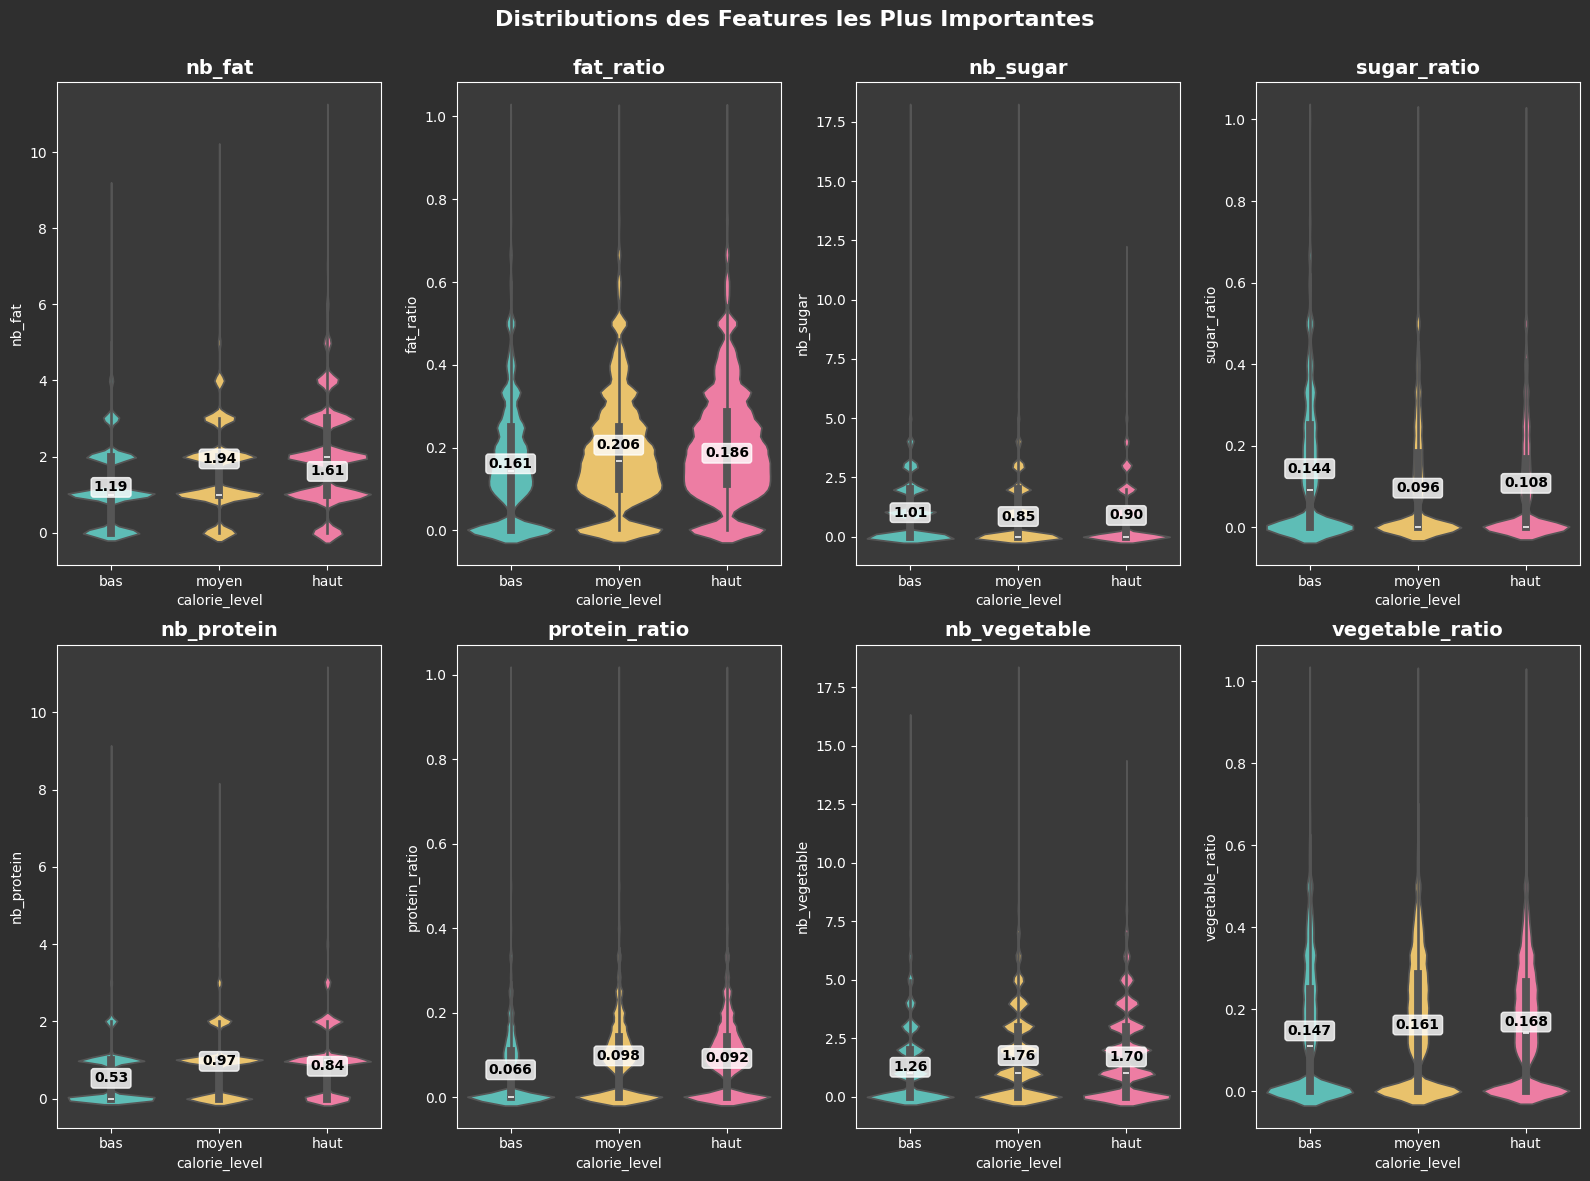

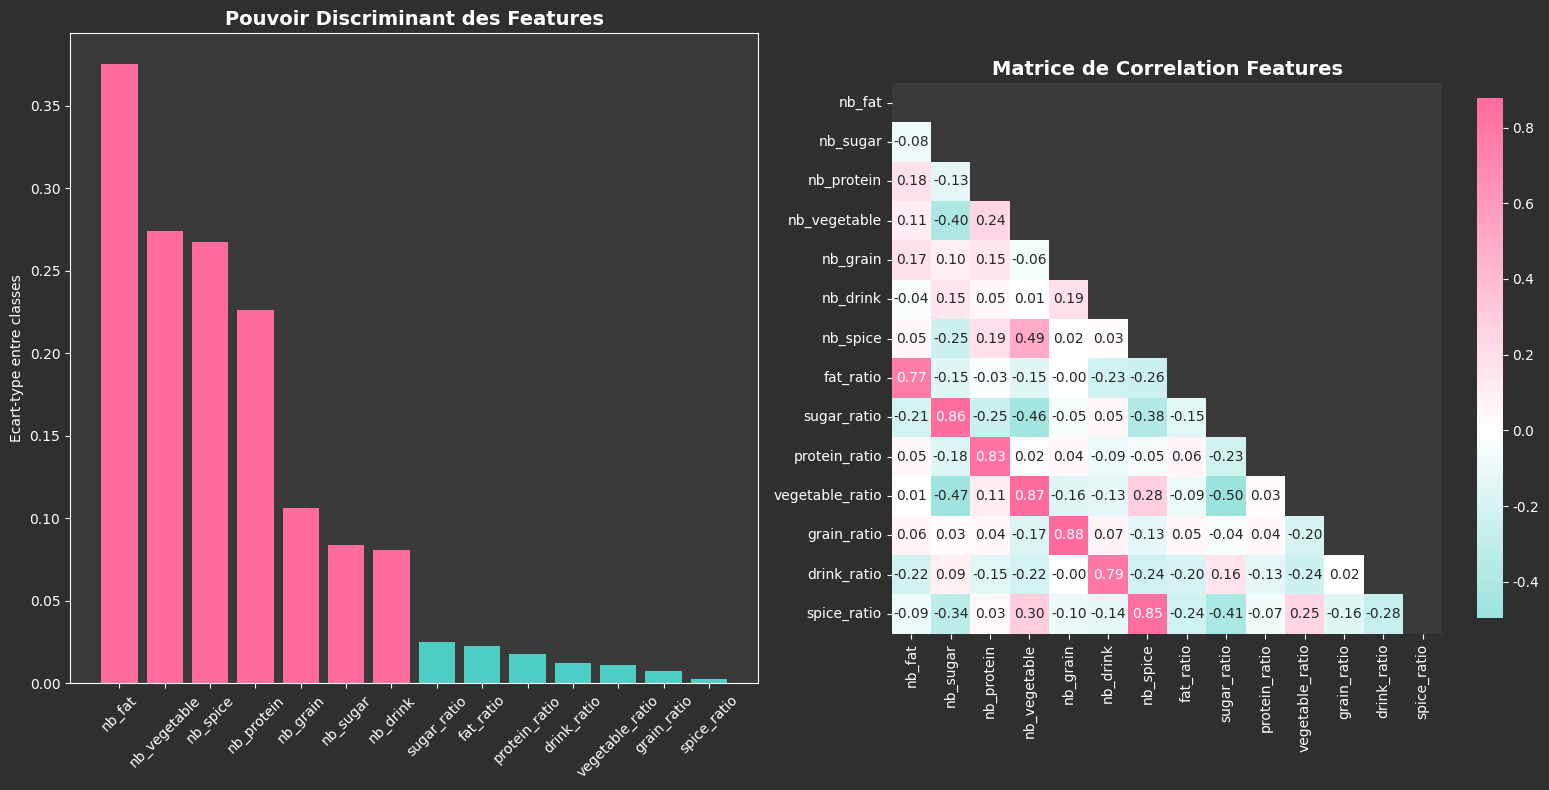

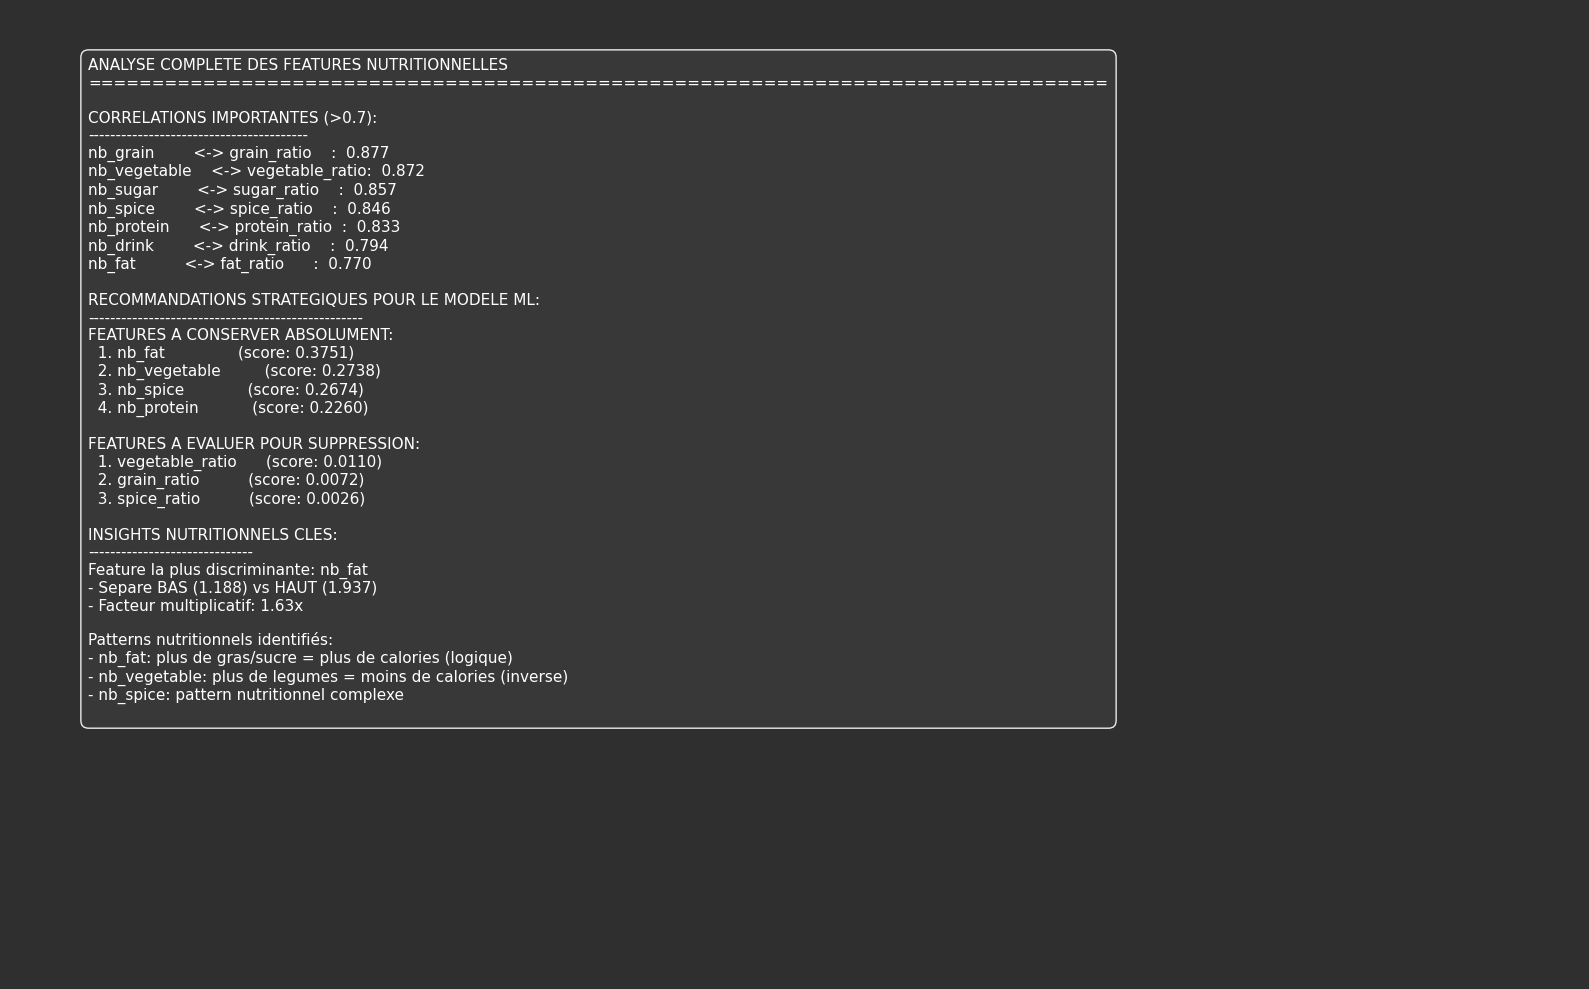

In [ ]:
plt.style.use('dark_background')
import matplotlib.colors as mcolors

class_colors = {'bas': '#4ECDC4', 'moyen': '#FECA57', 'haut': '#FF6B9D'}

# Paires de features (compteur + ratio correspondant)
feature_pairs = [
    ('nb_fat', 'fat_ratio'),
    ('nb_sugar', 'sugar_ratio'), 
    ('nb_protein', 'protein_ratio'),
    ('nb_vegetable', 'vegetable_ratio'),
    ('nb_grain', 'grain_ratio'),
    ('nb_drink', 'drink_ratio'),
    ('nb_spice', 'spice_ratio')
]

# ================================
# FIGURE 1: VIOLIN PLOTS
# ================================
fig1 = plt.figure(figsize=(16, 12))
fig1.patch.set_facecolor('#2F2F2F')

# Calculer d'abord les scores pour prendre les plus importantes
features_all = [pair[0] for pair in feature_pairs] + [pair[1] for pair in feature_pairs]
means_by_class = df.groupby('calorie_level')[features_all].mean()
discrimination_score = means_by_class.std(axis=0).sort_values(ascending=False)

# Identifier les 4 paires les plus importantes
important_features = discrimination_score.head(8).index.tolist()
important_pairs = []
for count_feat, ratio_feat in feature_pairs:
    if count_feat in important_features or ratio_feat in important_features:
        important_pairs.append((count_feat, ratio_feat))
important_pairs = important_pairs[:4]  # Garder seulement les 4 premières

for i, (count_feature, ratio_feature) in enumerate(important_pairs):
    row = i // 2 + 1  # 2 lignes
    col = (i % 2) * 2 + 1  # 2 colonnes de 2 subplots
    
    # Subplot pour le compteur
    ax1 = plt.subplot(2, 4, (row-1)*4 + col)
    ax1.set_facecolor('#3A3A3A')
    sns.violinplot(data=df, x='calorie_level', y=count_feature, palette=class_colors, ax=ax1)
    plt.title(f'{count_feature}', fontsize=14, fontweight='bold')
    
    # Ajouter les moyennes
    means = df.groupby('calorie_level')[count_feature].mean()
    for j, (level, mean_val) in enumerate(means.items()):
        plt.text(j, mean_val, f'{mean_val:.2f}', ha='center', va='center', 
                fontweight='bold', color='black', 
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))
    
    # Subplot pour le ratio correspondant
    ax2 = plt.subplot(2, 4, (row-1)*4 + col + 1)
    ax2.set_facecolor('#3A3A3A')
    sns.violinplot(data=df, x='calorie_level', y=ratio_feature, palette=class_colors, ax=ax2)
    plt.title(f'{ratio_feature}', fontsize=14, fontweight='bold')
    
    # Ajouter les moyennes
    means = df.groupby('calorie_level')[ratio_feature].mean()
    for j, (level, mean_val) in enumerate(means.items()):
        plt.text(j, mean_val, f'{mean_val:.3f}', ha='center', va='center', 
                fontweight='bold', color='black',
                bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

plt.suptitle('Distributions des Features les Plus Importantes', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

# ================================
# FIGURE 2: ANALYSES DISCRIMINANTES
# ================================
fig2 = plt.figure(figsize=(16, 8))
fig2.patch.set_facecolor('#2F2F2F')

colors = ['#4ECDC4', '#FFFFFF', '#FF6B9D']
n_bins = 256
cmap_custom = mcolors.LinearSegmentedColormap.from_list('blue_to_pink', colors, N=n_bins)

# Subplot 1: Pouvoir Discriminant
ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor('#3A3A3A')
bars = plt.bar(range(len(discrimination_score)), discrimination_score.values, 
               color=['#FF6B9D' if x > discrimination_score.median() else '#4ECDC4' 
                     for x in discrimination_score.values])
plt.title('Pouvoir Discriminant des Features', fontsize=14, fontweight='bold')
plt.xticks(range(len(discrimination_score)), discrimination_score.index, rotation=45)
plt.ylabel('Ecart-type entre classes')

# Subplot 2: Matrice de Corrélation avec palette personnalisée bleu vers rose
ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor('#3A3A3A')
correlation_matrix = df[features_all].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap=cmap_custom, center=0,
           square=True, fmt='.2f', cbar_kws={"shrink": .8}, ax=ax2)
plt.title('Matrice de Correlation Features', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# ================================
# FIGURE 3: RÉCAPITULATIF COMPLET
# ================================
fig3 = plt.figure(figsize=(16, 10))
fig3.patch.set_facecolor('#2F2F2F')  # Fond moins noir
plt.axis('off')

# Statistiques détaillées
stats_text = "ANALYSE COMPLETE DES FEATURES NUTRITIONNELLES\n" + "="*80 + "\n\n"

# Corrélations importantes
stats_text += "CORRELATIONS IMPORTANTES (>0.7):\n"
stats_text += "-" * 40 + "\n"
corr_pairs = []
for i in range(len(features_all)):
    for j in range(i+1, len(features_all)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            corr_pairs.append((features_all[i], features_all[j], corr_val))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
for feat1, feat2, corr in corr_pairs:
    stats_text += f"{feat1:<15} <-> {feat2:<15}: {corr:6.3f}\n"

# Recommandations stratégiques
stats_text += "\nRECOMMANDATIONS STRATEGIQUES POUR LE MODELE ML:\n"
stats_text += "-" * 50 + "\n"
top_features = discrimination_score.head(4).index.tolist()
weak_features = discrimination_score.tail(3).index.tolist()

stats_text += "FEATURES A CONSERVER ABSOLUMENT:\n"
for i, feat in enumerate(top_features, 1):
    score = discrimination_score[feat]
    stats_text += f"  {i}. {feat:<20} (score: {score:.4f})\n"

stats_text += "\nFEATURES A EVALUER POUR SUPPRESSION:\n"
for i, feat in enumerate(weak_features, 1):
    score = discrimination_score[feat]
    stats_text += f"  {i}. {feat:<20} (score: {score:.4f})\n"

# Insights nutritionnels
stats_text += "\nINSIGHTS NUTRITIONNELS CLES:\n"
stats_text += "-" * 30 + "\n"
top_feature = discrimination_score.index[0]
bas_val = df[df['calorie_level'] == 'bas'][top_feature].mean()
haut_val = df[df['calorie_level'] == 'haut'][top_feature].mean()

stats_text += f"Feature la plus discriminante: {top_feature}\n"
stats_text += f"- Separe BAS ({bas_val:.3f}) vs HAUT ({haut_val:.3f})\n"
stats_text += f"- Facteur multiplicatif: {haut_val/bas_val:.2f}x\n\n"

stats_text += "Patterns nutritionnels identifiés:\n"
for feature in discrimination_score.head(3).index:
    bas_mean = df[df['calorie_level'] == 'bas'][feature].mean()
    haut_mean = df[df['calorie_level'] == 'haut'][feature].mean()
    if "fat" in feature or "sugar" in feature:
        interpretation = "plus de gras/sucre = plus de calories (logique)"
    elif "vegetable" in feature:
        interpretation = "plus de legumes = moins de calories (inverse)"
    else:
        interpretation = "pattern nutritionnel complexe"
    stats_text += f"- {feature}: {interpretation}\n"

plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="#3A3A3A", alpha=0.9))

plt.tight_layout()
plt.show()

## 8. Préparation des données d'entrainement (X, y)

In [8]:
# LabelEncoder pour les classes, et en plus ça garantit l'ordre des classes
le = LabelEncoder()
le.fit(['bas', 'moyen', 'haut'])

y_encoded = le.transform(df['calorie_level'])

tfidf = TfidfVectorizer(
    max_features=300,
    min_df=100,
    max_df=0.95, 
    ngram_range=(1, 1),
    stop_words=None
)

# Vectoriser le texte
X_tfidf = tfidf.fit_transform(df['ingredients_cleaned'])

# Features numériques
numeric_features = [
    'n_ingredients', 
    'nb_fat', 'nb_sugar', 'nb_drink', 'nb_protein', 'nb_vegetable', 'nb_grain', 'nb_spice', 
    'fat_ratio', 'sugar_ratio', 'drink_ratio', 'protein_ratio', 'vegetable_ratio', 'grain_ratio', 'spice_ratio'
]

# Normaliser les features numériques
scaler = StandardScaler()
X_numeric = scaler.fit_transform(df[numeric_features])

# Convertir les features numériques (dense numpy array) en sparse
X_numeric_sparse = csr_matrix(X_numeric)

# Combiner TF-IDF + features numériques + features catégorielles
X_combined = hstack([X_tfidf, X_numeric_sparse])

# Labels de classification encodés
y = y_encoded

print(f"Forme de la matrice TF-IDF: {X_tfidf.shape}")
print(f"Forme des features numériques: {X_numeric.shape}")
print(f"Forme de la matrice hybride: {X_combined.shape}")

# Division des données
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

print(f"\nTaille du dataset:")
print(f"- Jeu d'entraînement: {X_train.shape[0]:,} échantillons")
print(f"- Jeu de test: {X_test.shape[0]:,} échantillons")

Forme de la matrice TF-IDF: (228430, 300)
Forme des features numériques: (228430, 15)
Forme de la matrice hybride: (228430, 315)

Taille du dataset:
- Jeu d'entraînement: 182,744 échantillons
- Jeu de test: 45,686 échantillons


## 9. Optimisation des Hyperparamètres avec XGBoost

In [ ]:
print("Configuration XGBoost:")

xgb_balanced_base = xgb.XGBClassifier(
    objective='multi:softprob',
    n_jobs=-1,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=1,
    tree_method='hist',
    # Hyperparamètres par défaut
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.2,
    reg_lambda=1.2
)

print(f"Configuration XGBoost:")
print(f"- objective: {xgb_balanced_base.objective}")
print(f"- tree_method: {xgb_balanced_base.tree_method}")
print(f"- learning_rate: {xgb_balanced_base.learning_rate}")
print(f"- n_estimators: {xgb_balanced_base.n_estimators}")
print(f"- max_depth: {xgb_balanced_base.max_depth}")

# Validation croisée stratifiée
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparamètres à optimiser
param_xgb_balanced = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0.1, 0.2, 0.3],
    'reg_lambda': [1.0, 1.2, 1.5]
}

search_xgb_balanced = RandomizedSearchCV(
    estimator=xgb_balanced_base,
    param_distributions=param_xgb_balanced,
    n_iter=20,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print(f"\nOptimisation des hyperparamètres:")
print(f"- CV stratifié: {stratified_cv.n_splits} folds")
print(f"- Scoring: accuracy (simple et efficace)")
print(f"- Paramètres testés: {search_xgb_balanced.n_iter}")

Configuration XGBoost:
Configuration XGBoost:
- objective: multi:softprob
- tree_method: hist
- learning_rate: 0.1
- n_estimators: 200
- max_depth: 6

Optimisation des hyperparamètres:
- CV stratifié: 5 folds
- Scoring: accuracy (simple et efficace)
- Paramètres testés: 20


## 10. Entraînement avec XGBoost

In [10]:
print("\nDémarrage de l'entraînement...")

# Entraînement
search_xgb_balanced.fit(X_train, y_train)

print(f"\nOptimisation terminée!")
print(f"- Meilleurs paramètres: {search_xgb_balanced.best_params_}")
print(f"- Meilleur score accuracy: {search_xgb_balanced.best_score_:.4f}")

# Récupération du meilleur modèle
best_xgb = search_xgb_balanced.best_estimator_


Démarrage de l'entraînement...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Optimisation terminée!
- Meilleurs paramètres: {'subsample': 0.7, 'reg_lambda': 1.2, 'reg_alpha': 0.2, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.9}
- Meilleur score accuracy: 0.5309


## 11. Récapitulatif sur le meilleur modèle sélectionné

In [11]:
print(f"\nPARAMÈTRES FINAUX:")
print(f"- objective: {best_xgb.objective}")
print(f"- min_child_weight: {best_xgb.min_child_weight}")
print(f"- gamma: {best_xgb.gamma}")
print(f"- reg_alpha: {best_xgb.reg_alpha}")
print(f"- reg_lambda: {best_xgb.reg_lambda}")
print(f"- tree_method: {best_xgb.tree_method}")
print(f"- n_estimators: {best_xgb.n_estimators}")
print(f"- max_depth: {best_xgb.max_depth}")
print(f"- learning_rate: {best_xgb.learning_rate}")

print(f"\nRÉCAPITULATIF DE L'APPROCHE:")
print(f"- Données: originales")
print(f"- Équilibrage: sample weights calculés")
print(f"- Métrique: accuracy")
print(f"- Validation: StratifiedKFold (5 folds)")
print(f"- Optimisation: RandomizedSearchCV (20 itérations)")
print(f"- Performance: {search_xgb_balanced.best_score_:.4f} accuracy")


PARAMÈTRES FINAUX:
- objective: multi:softprob
- min_child_weight: 5
- gamma: 0.1
- reg_alpha: 0.2
- reg_lambda: 1.2
- tree_method: hist
- n_estimators: 300
- max_depth: 8
- learning_rate: 0.05

RÉCAPITULATIF DE L'APPROCHE:
- Données: originales
- Équilibrage: sample weights calculés
- Métrique: accuracy
- Validation: StratifiedKFold (5 folds)
- Optimisation: RandomizedSearchCV (20 itérations)
- Performance: 0.5309 accuracy


## 12. Évaluation complète du meilleur modèle sélectionné

Accuracy d'entraînement: 0.5896
Accuracy de test: 0.5330

Rapport de classification (jeu de test):
              precision    recall  f1-score   support

         bas       0.56      0.68      0.61     15208
       moyen       0.57      0.50      0.53     15032
        haut       0.46      0.42      0.44     15446

    accuracy                           0.53     45686
   macro avg       0.53      0.53      0.53     45686
weighted avg       0.53      0.53      0.53     45686



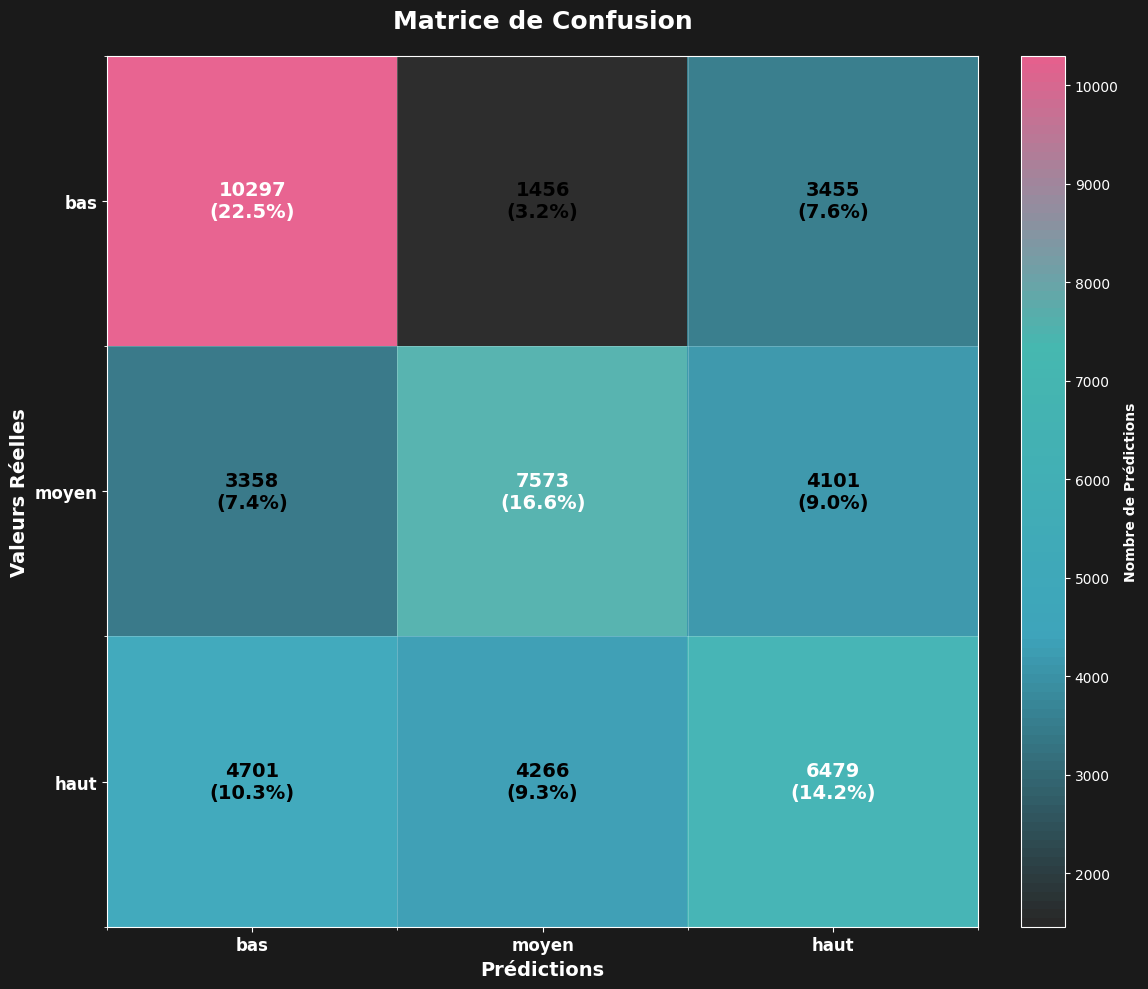


Scores de validation croisée: [0.53328408 0.52863279 0.52707324 0.53153301 0.53343548]
Score moyen: 0.5308 (+/- 0.0051)


In [ ]:
# Prédictions
y_pred_train = best_xgb.predict(X_train)
y_pred_test = best_xgb.predict(X_test)

# Scores d'accuracy
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"Accuracy de test: {test_accuracy:.4f}")

# Rapport de classification
print("\nRapport de classification (jeu de test):")
print(classification_report(y_test, y_pred_test, target_names=['bas', 'moyen', 'haut']))

# Matrice de confusion
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#2d2d2d')

cm = confusion_matrix(y_test, y_pred_test)

# Créer un heatmap personnalisé
import matplotlib.colors as mcolors

colors = ['#2d2d2d', '#45B7D1', '#4ECDC4', '#FF6B9D']
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors, N=n_bins)

im = ax.imshow(cm, interpolation='nearest', cmap=cmap, alpha=0.9)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax.text(j, i, f'{cm[i, j]}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', fontweight='bold',
                color=text_color, fontsize=14)

class_names = ['bas', 'moyen', 'haut']
ax.set_xticks(range(len(class_names)))
ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, fontsize=12, color='white', fontweight='bold')
ax.set_yticklabels(class_names, fontsize=12, color='white', fontweight='bold')

ax.set_title('Matrice de Confusion', fontsize=18, fontweight='bold', 
             color='white', pad=20)
ax.set_xlabel('Prédictions', fontsize=14, fontweight='bold', color='white')
ax.set_ylabel('Valeurs Réelles', fontsize=14, fontweight='bold', color='white')

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color='white')
cbar.ax.tick_params(labelcolor='white')
cbar.set_label('Nombre de Prédictions', color='white', fontweight='bold')

ax.set_xticks(np.arange(len(class_names) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(class_names) + 1) - 0.5, minor=True)
ax.grid(which='minor', color='white', linestyle='-', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()

# Validation croisée
cv_scores = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nScores de validation croisée: {cv_scores}")
print(f"Score moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

## 13. Importance des features

Nombre de noms de features: 315
Nombre d'importances: 315
Match: True


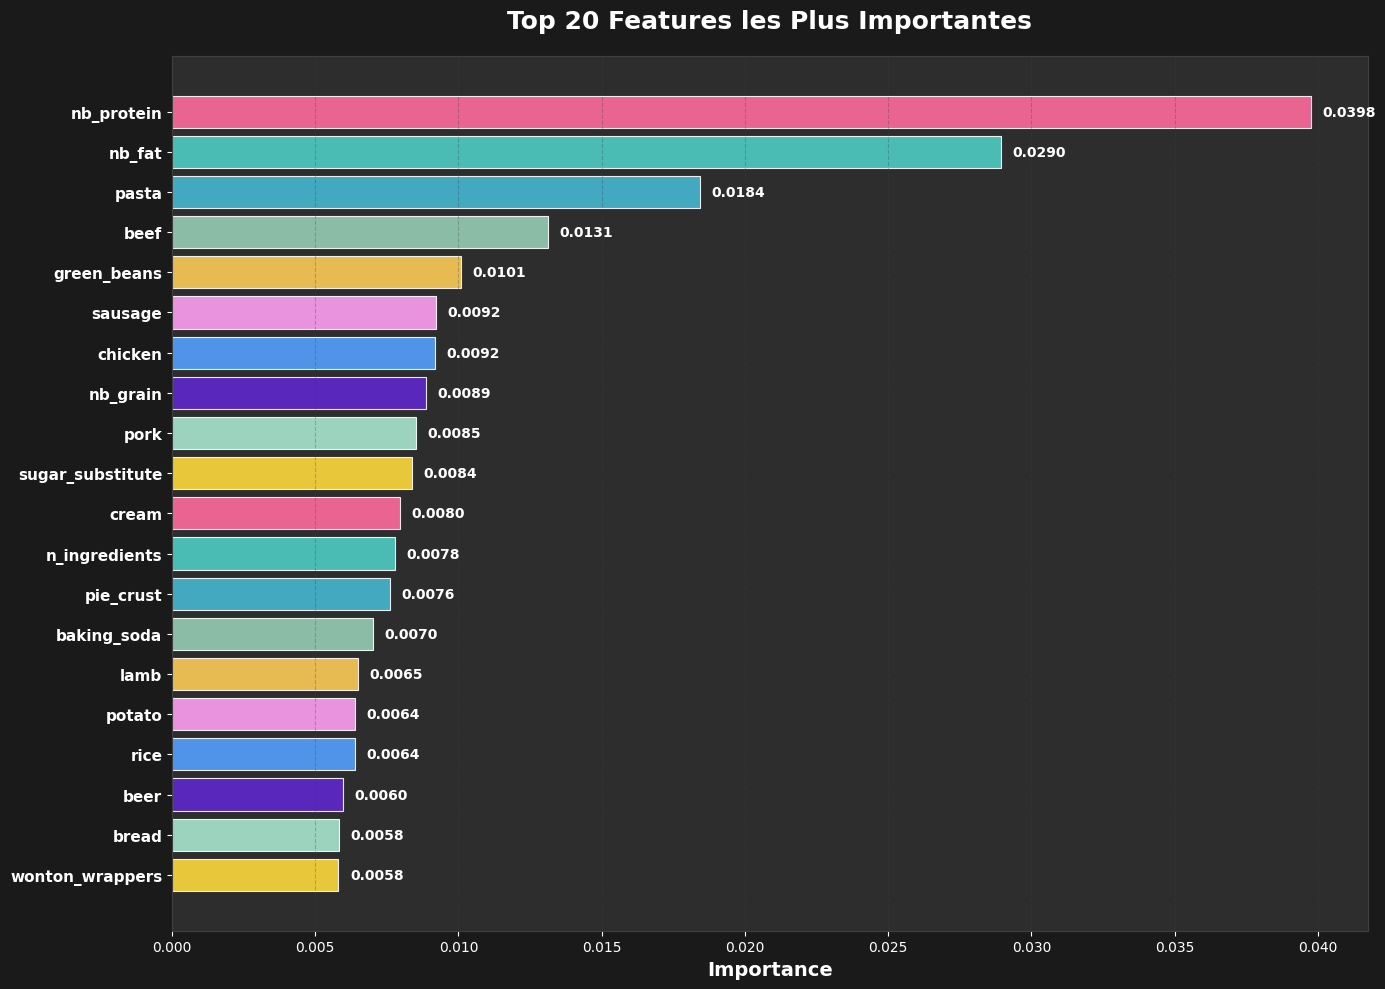

Top 10 des features les plus importantes:
              feature  importance
304        nb_protein    0.039755
301            nb_fat    0.028951
193             pasta    0.018434
27               beef    0.013132
124       green_beans    0.010091
243           sausage    0.009202
59            chicken    0.009183
306          nb_grain    0.008872
206              pork    0.008521
260  sugar_substitute    0.008370

ANALYSE PAR TYPE DE FEATURE

Top 5 Features Numériques:
           feature  importance
304     nb_protein    0.039755
301         nb_fat    0.028951
306       nb_grain    0.008872
300  n_ingredients    0.007777
313    grain_ratio    0.004995

Top 5 Features TF-IDF (ingrédients):
         feature  importance
193        pasta    0.018434
27          beef    0.013132
124  green_beans    0.010091
243      sausage    0.009202
59       chicken    0.009183


In [ ]:
# Récupération des noms de features
def get_all_feature_names(tfidf_vectorizer, numeric_features):
    """Récupère tous les noms de features dans le bon ordre"""
    # 1. Features TF-IDF
    tfidf_names = list(tfidf_vectorizer.get_feature_names_out())
    
    # 2. Features numériques 
    numeric_names = numeric_features.copy()
    
    # Combiner dans le même ordre que lors de la création de X_combined
    all_feature_names = tfidf_names + numeric_names
    
    return all_feature_names

numeric_features_list = [
    'n_ingredients', 
    'nb_fat', 'nb_sugar', 'nb_drink', 'nb_protein', 'nb_vegetable', 'nb_grain', 'nb_spice', 
    'fat_ratio', 'sugar_ratio', 'drink_ratio', 'protein_ratio', 'vegetable_ratio', 'grain_ratio', 'spice_ratio'
]

# Obtenir TOUS les noms de features
all_feature_names = get_all_feature_names(tfidf, numeric_features_list)
feature_importance = best_xgb.feature_importances_

print(f"Nombre de noms de features: {len(all_feature_names)}")
print(f"Nombre d'importances: {len(feature_importance)}")
print(f"Match: {len(all_feature_names) == len(feature_importance)}")

# Créer le DataFrame des importances
importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

fig, ax = plt.subplots(figsize=(14, 10))
fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#2d2d2d')

top_features = importance_df.head(20)

beautiful_colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', 
                   '#FF9FF3', '#54A0FF', '#5F27CD', '#A8E6CF', '#FFD93D']

colors_bars = [beautiful_colors[i % len(beautiful_colors)] for i in range(len(top_features))]
bars = ax.barh(range(len(top_features)), top_features['importance'],
               color=colors_bars, alpha=0.9, 
               edgecolor='white', linewidth=0.8)

# Configuration des axes
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'], fontsize=11, color='white', fontweight='bold')
ax.set_xlabel('Importance', fontweight='bold', color='white', fontsize=14)
ax.set_title('Top 20 Features les Plus Importantes', 
             fontweight='bold', fontsize=18, color='white', pad=20)

for i, (bar, importance) in enumerate(zip(bars, top_features['importance'])):
    ax.text(bar.get_width() + max(top_features['importance'])*0.01, 
            bar.get_y() + bar.get_height()/2, 
            f'{importance:.4f}', 
            ha='left', va='center', fontweight='bold', 
            color='white', fontsize=10)

ax.invert_yaxis()
ax.tick_params(colors='white')
ax.grid(True, alpha=0.3, color='#404040', linestyle='--', axis='x')

for spine in ax.spines.values():
    spine.set_color('#404040')

plt.tight_layout()
plt.show()

print("Top 10 des features les plus importantes:")
print(importance_df.head(10))

# Analyse par type de feature
print("\n" + "="*60)
print("ANALYSE PAR TYPE DE FEATURE")
print("="*60)

# Top features numériques
numeric_importance = importance_df[importance_df['feature'].isin(numeric_features_list)]
print("\nTop 5 Features Numériques:")
print(numeric_importance.head())

# Top features TF-IDF
tfidf_importance = importance_df[~importance_df['feature'].isin(numeric_features_list)]
print("\nTop 5 Features TF-IDF (ingrédients):")
print(tfidf_importance.head())

## 14. Analyse SHAP pour l'explicabilité

Initialisation de l'explainer SHAP...
Calcul des valeurs SHAP pour 100 échantillons...
Analyse SHAP terminée!
Forme shap_values: (100, 315, 3)
Forme X_test_sample: (100, 315)
Nombre de feature names: 315


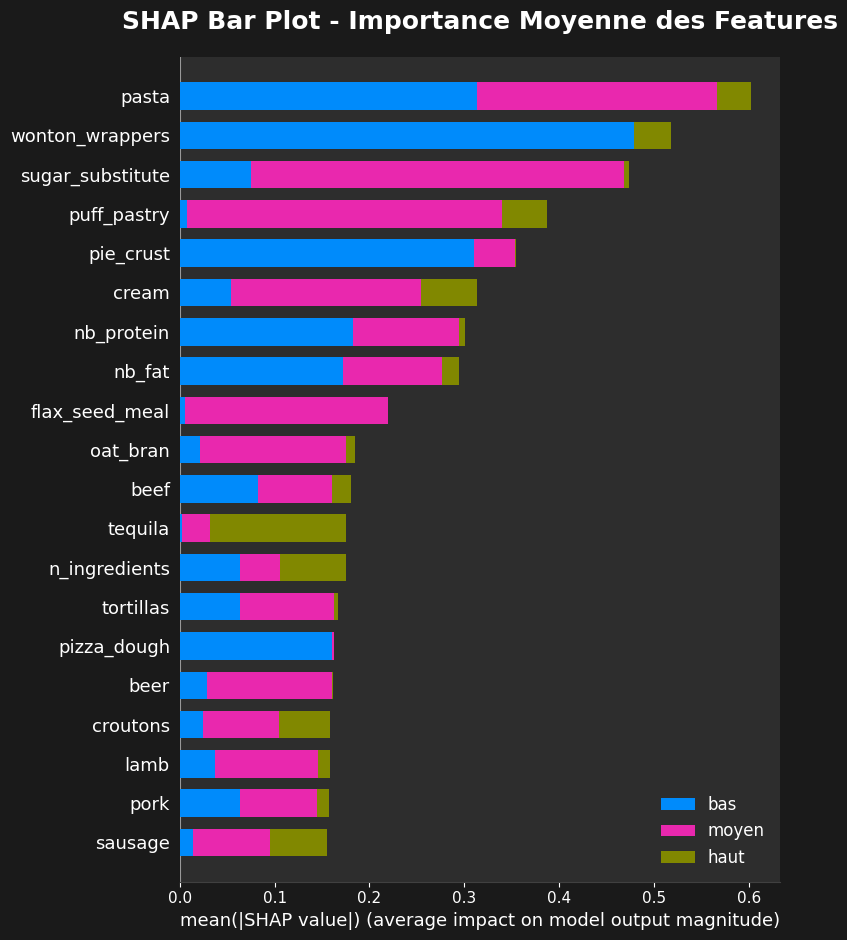


ANALYSE SHAP PAR TYPE DE FEATURE
DEBUG: Forme de shap_values: (100, 315, 3)
DEBUG: Forme de mean_shap_importance: (315,)
Top 10 Features selon SHAP:
              feature  shap_importance
193             pasta         0.200885
294   wonton_wrappers         0.172530
260  sugar_substitute         0.157960
212       puff_pastry         0.128974
201         pie_crust         0.118281
91              cream         0.104460
304        nb_protein         0.100151
301            nb_fat         0.097990
111    flax_seed_meal         0.073233
175          oat_bran         0.061679

Comparaison XGBoost vs SHAP (Top 10):
            feature  importance  shap_importance  rank_xgb  rank_shap
0        nb_protein    0.039755         0.100151       1.0        7.0
1            nb_fat    0.028951         0.097990       2.0        8.0
2             pasta    0.018434         0.200885       3.0        1.0
3              beef    0.013132         0.060358       4.0       11.0
4       green_beans    0.010091 

In [ ]:
print("Initialisation de l'explainer SHAP...")
explainer = shap.TreeExplainer(best_xgb)

# Calculer les valeurs SHAP sur un échantillon
sample_size = min(100, X_test.shape[0])
X_test_sample = X_test[:sample_size].toarray().astype(np.float64)
y_test_sample = y_test[:sample_size]

print(f"Calcul des valeurs SHAP pour {sample_size} échantillons...")
shap_values = explainer.shap_values(X_test_sample)

print("Analyse SHAP terminée!")

# Vérification des dimensions
print(f"Forme shap_values: {np.array(shap_values).shape}")
print(f"Forme X_test_sample: {X_test_sample.shape}")
print(f"Nombre de feature names: {len(all_feature_names)}")

# Bar plot SHAP
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('#1a1a1a')

shap.summary_plot(shap_values, X_test_sample, 
                  feature_names=all_feature_names,
                  plot_type="bar", 
                  class_names=['bas', 'moyen', 'haut'], 
                  show=False)

ax = plt.gca()
ax.set_facecolor('#2d2d2d')
ax.set_title('SHAP Bar Plot - Importance Moyenne des Features', 
             fontweight='bold', fontsize=18, color='white', pad=20)

ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

for spine in ax.spines.values():
    spine.set_color('#404040')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALYSE SHAP PAR TYPE DE FEATURE")
print("="*60)

print(f"DEBUG: Forme de shap_values: {np.array(shap_values).shape}")

if isinstance(shap_values, list):  
    # Cas 1: shap_values est une liste d'arrays (rare)
    mean_shap_importance = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
else:
    # Cas 2: shap_values est un array 3D ← notre cas
    if len(shap_values.shape) == 3:
        # Prendre la moyenne absolue sur les échantillons (axis=0) et les classes (axis=2)
        mean_shap_importance = np.abs(shap_values).mean(axis=0).mean(axis=1)
    else:
        # Cas classique 2D
        mean_shap_importance = np.abs(shap_values).mean(axis=0)

print(f"DEBUG: Forme de mean_shap_importance: {mean_shap_importance.shape}")

# Vérification avant création du DataFrame
if mean_shap_importance.ndim != 1:
    print(f"ERREUR: mean_shap_importance doit être 1D, mais a {mean_shap_importance.ndim} dimensions")
    print(f"Forme actuelle: {mean_shap_importance.shape}")
    # Forcer à 1D si nécessaire
    mean_shap_importance = mean_shap_importance.flatten()

# Créer DataFrame SHAP
shap_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'shap_importance': mean_shap_importance
}).sort_values('shap_importance', ascending=False)

print("Top 10 Features selon SHAP:")
print(shap_importance_df.head(10))

# Comparaison XGBoost vs SHAP importance
comparison_df = importance_df.merge(shap_importance_df, on='feature', how='inner')
comparison_df['rank_xgb'] = comparison_df['importance'].rank(ascending=False)
comparison_df['rank_shap'] = comparison_df['shap_importance'].rank(ascending=False)
comparison_df['rank_diff'] = abs(comparison_df['rank_xgb'] - comparison_df['rank_shap'])

print(f"\nComparaison XGBoost vs SHAP (Top 10):")
print(comparison_df.head(10)[['feature', 'importance', 'shap_importance', 'rank_xgb', 'rank_shap']])

## 15. Prédictions

15.1. Fonction de prédiction

In [ ]:
def predict_calorie_level(ingredients_text):
    """
    Prédit le niveau calorique avec TOUTES les nouvelles features
    
    Args:
        ingredients_text (str): Liste des ingrédients
    
    Returns:
        tuple: (prédiction, probabilités)
    """

    # TODO SORTIR LE TRAITEMENT DANS UNE FONCTION COMPLETE REUTILISABLE
    
    # === ÉTAPE 1: PREPROCESSING ===
    ingredients_sorted = sort_ingredients(ingredients_text)
    ingredients_cleaned = clean_text(ingredients_sorted)
    
    print(f"Original: {ingredients_text}")
    print(f"Cleaned: {ingredients_cleaned}")
    
    # === ÉTAPE 2: TF-IDF ===
    text_vectorized = tfidf.transform([ingredients_cleaned])
    
    # === ÉTAPE 3: FONCTIONS DE COMPTAGE GÉNÉRIQUES ===
    def count_ingredients_single(ingredients_cleaned, ingredient_list):
        """Fonction générique pour compter une catégorie d'ingrédients"""
        ingredients_list = ingredients_cleaned.lower().split()
        count = 0
        
        for ingredient in ingredients_list:
            if ingredient in ingredient_list:
                count += 1
            else:
                for target_ing in ingredient_list:
                    if target_ing in ingredient:
                        count += 1
                        break
        return count
    
    # === ÉTAPE 4: CALCUL DES FEATURES NUMÉRIQUES COMPLÈTES ===
    n_ingredients = len(ingredients_cleaned.split())
    
    # Compteurs par catégorie
    nb_fat = count_ingredients_single(ingredients_cleaned, fat_ingredients)
    nb_sugar = count_ingredients_single(ingredients_cleaned, sugar_ingredients)
    nb_drink = count_ingredients_single(ingredients_cleaned, drink_ingredients)
    nb_protein = count_ingredients_single(ingredients_cleaned, protein_ingredients)
    nb_vegetable = count_ingredients_single(ingredients_cleaned, vegetable_ingredients)
    nb_grain = count_ingredients_single(ingredients_cleaned, grain_ingredients)
    nb_spice = count_ingredients_single(ingredients_cleaned, spice_ingredients)
    
    # Ratios avec epsilon
    epsilon = 1e-6
    fat_ratio = nb_fat / (n_ingredients + epsilon)
    sugar_ratio = nb_sugar / (n_ingredients + epsilon)
    drink_ratio = nb_drink / (n_ingredients + epsilon)
    protein_ratio = nb_protein / (n_ingredients + epsilon)
    vegetable_ratio = nb_vegetable / (n_ingredients + epsilon)
    grain_ratio = nb_grain / (n_ingredients + epsilon)
    spice_ratio = nb_spice / (n_ingredients + epsilon)
    
    print(f"Features numériques calculées:")
    print(f"- n_ingredients: {n_ingredients}")
    print(f"- Compteurs: fat={nb_fat}, sugar={nb_sugar}, protein={nb_protein}, vegetable={nb_vegetable}")
    print(f"- Compteurs: grain={nb_grain}, drink={nb_drink}, spice={nb_spice}")
    print(f"- Ratios: fat={fat_ratio:.3f}, sugar={sugar_ratio:.3f}, protein={protein_ratio:.3f}")
    
    # Vecteur numérique
    numeric_values = np.array([[
        n_ingredients, nb_fat, nb_sugar, nb_drink, nb_protein, 
        nb_vegetable, nb_grain, nb_spice,
        fat_ratio, sugar_ratio, drink_ratio, protein_ratio, 
        vegetable_ratio, grain_ratio, spice_ratio
    ]])
    
    # Normalisation
    numeric_normalized = scaler.transform(numeric_values)
    numeric_sparse = csr_matrix(numeric_normalized)
    
    # Combinaison des features
    X_combined_prediction = hstack([text_vectorized, numeric_sparse])
    
    print(f"\nDimensions finales:")
    print(f"- TF-IDF: {text_vectorized.shape}")
    print(f"- Numériques: {numeric_sparse.shape}")
    print(f"- Combinées: {X_combined_prediction.shape}")
    print(f"- Modèle attend: {X_train.shape[1]} features")
    
    # Vérification des dimensions
    if X_combined_prediction.shape[1] != X_train.shape[1]:
        print(f"ERREUR: Mismatch de dimensions!")
        print(f"Attendu: {X_train.shape[1]}, Reçu: {X_combined_prediction.shape[1]}")
        return None, None
    
    # Prédiction
    prediction_encoded = best_xgb.predict(X_combined_prediction)[0]
    probabilities = best_xgb.predict_proba(X_combined_prediction)[0]
    
    # Décoder
    prediction = le.inverse_transform([prediction_encoded])[0]
    class_names = le.classes_
    prob_dict = dict(zip(class_names, probabilities))
    
    print(f"\nRésultat:")
    print(f"- Prédiction: {prediction}")
    print(f"- Confiance: {max(prob_dict.values()):.1%}")
    for class_name, prob in prob_dict.items():
        print(f"- {class_name}: {prob:.1%}")
    
    return prediction, prob_dict

# test simple
test_ingredients = "['chicken', 'olive_oil', 'garlic', 'tomatoes', 'basil']"
prediction, probabilities = predict_calorie_level(test_ingredients)

Original: ['chicken', 'olive_oil', 'garlic', 'tomatoes', 'basil']
Cleaned: basil chicken garlic olive_oil tomatoes
Features numériques calculées:
- n_ingredients: 5
- Compteurs: fat=1, sugar=0, protein=1, vegetable=2
- Compteurs: grain=0, drink=0, spice=1
- Ratios: fat=0.200, sugar=0.000, protein=0.200

Dimensions finales:
- TF-IDF: (1, 300)
- Numériques: (1, 15)
- Combinées: (1, 315)
- Modèle attend: 315 features

Résultat:
- Prédiction: moyen
- Confiance: 44.4%
- bas: 30.8%
- haut: 24.8%
- moyen: 44.4%


15.2. Visualisation d'une prédiction

In [ ]:
def visualize_prediction(ingredients_text):
    """
    Visualise une prédiction avec le thème harmonisé - VERSION CORRIGÉE
    
    Args:
        ingredients_text (str): Liste des ingrédients
    """
    # Prédiction
    prediction, prob_dict = predict_calorie_level(ingredients_text)
    
    # Viz
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    fig.patch.set_facecolor('#1a1a1a')
    
    # Graphique des probabilités (camembert)
    ax1.set_facecolor('#2d2d2d')
    
    category_colors = {'bas': '#96CEB4', 'moyen': '#4ECDC4', 'haut': '#FF6B9D'}
    colors = [category_colors[cat] for cat in prob_dict.keys()]
    
    explode = [0.1 if cat == prediction else 0 for cat in prob_dict.keys()]
    
    wedges, texts, autotexts = ax1.pie(prob_dict.values(), 
                                      labels=[f'{cat.upper()}\n{prob:.1%}' for cat, prob in prob_dict.items()],
                                      colors=colors, explode=explode, autopct='',
                                      shadow=True, startangle=90,
                                      textprops={'fontsize': 12, 'color': 'white', 'fontweight': 'bold'})
    
    ax1.set_title(f'Prédiction: {prediction.upper()}', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
    
    # Graphique en barres des probabilités
    ax2.set_facecolor('#2d2d2d')
    
    categories = list(prob_dict.keys())
    probabilities = list(prob_dict.values())
    colors_bars = [category_colors[cat] for cat in categories]
    
    bars = ax2.bar(categories, probabilities, color=colors_bars, alpha=0.9,
                   edgecolor='white', linewidth=1.5)
 
    for i, (bar, cat) in enumerate(zip(bars, categories)):
        if cat == prediction:
            bar.set_edgecolor('#FFD93D')
            bar.set_linewidth(3)
        
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{probabilities[i]:.1%}', ha='center', va='bottom',
                fontweight='bold', color='white', fontsize=12)
    
    ax2.set_title('Probabilités par Catégorie', 
                 fontweight='bold', fontsize=16, color='white', pad=20)
    ax2.set_ylabel('Probabilité', fontweight='bold', color='white')
    ax2.tick_params(colors='white')
    ax2.grid(True, alpha=0.3, color='#404040', linestyle='--')
    
    for spine in ax2.spines.values():
        spine.set_color('#404040')
    
    # Texte des ingrédients
    ax3.set_facecolor('#2d2d2d')
    ax3.axis('off')
    
    ingredients_clean = clean_text(ingredients_text)
    ingredients_words = ingredients_clean.split()
    
    ingredients_display = ', '.join(ingredients_words[:10])
    if len(ingredients_words) > 10:
        ingredients_display += f"... (+{len(ingredients_words) - 10} mots)"
    
    info_text = f"""
    ANALYSE DE LA RECETTE

    Prédiction: {prediction.upper()}
    Confiance: {max(prob_dict.values()):.1%}

    Ingrédients analysés:
    {ingredients_display}

    Nombre de termes: {len(ingredients_words)}
    Longueur du texte: {len(ingredients_text)} caractères
    """
    
    ax3.text(0.05, 0.95, info_text, transform=ax3.transAxes, 
             fontsize=11, color='white', va='top', ha='left',
             bbox=dict(boxstyle="round,pad=0.5", facecolor='#404040', alpha=0.8))
    
    # Features TF-IDF de cette prédiction
    ax4.set_facecolor('#2d2d2d')
    
    text_vectorized = tfidf.transform([ingredients_clean])
    
    if text_vectorized.nnz > 0:
        feature_indices = text_vectorized.nonzero()[1]
        feature_scores = text_vectorized.data
        
        # Utiliser les noms TF-IDF valides
        tfidf_feature_names = tfidf.get_feature_names_out()
        prediction_features = pd.DataFrame({
            'feature': [tfidf_feature_names[i] for i in feature_indices],
            'score': feature_scores
        }).sort_values('score', ascending=False).head(10)
        
        beautiful_colors = ['#FF6B9D', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
        colors_features = [beautiful_colors[i % len(beautiful_colors)] for i in range(len(prediction_features))]
        bars = ax4.barh(range(len(prediction_features)), prediction_features['score'],
                       color=colors_features, alpha=0.9, 
                       edgecolor='white', linewidth=0.8)
        
        ax4.set_yticks(range(len(prediction_features)))
        ax4.set_yticklabels(prediction_features['feature'], fontsize=10, color='white')
        ax4.set_xlabel('Score TF-IDF', fontweight='bold', color='white')
        ax4.set_title('Top Features TF-IDF de cette Recette', 
                     fontweight='bold', fontsize=14, color='white', pad=15)
        
        for i, (bar, score) in enumerate(zip(bars, prediction_features['score'])):
            ax4.text(bar.get_width() + max(prediction_features['score'])*0.02, 
                    bar.get_y() + bar.get_height()/2, 
                    f'{score:.3f}', 
                    ha='left', va='center', fontweight='bold', 
                    color='white', fontsize=9)
        
        ax4.invert_yaxis()
        ax4.tick_params(colors='white')
        ax4.grid(True, alpha=0.3, color='#404040', linestyle='--', axis='x')
    else:
        ax4.text(0.5, 0.5, 'Aucune feature trouvée', ha='center', va='center',
                transform=ax4.transAxes, color='white', fontsize=14)
    
    for spine in ax4.spines.values():
        spine.set_color('#404040')
    
    fig.suptitle(f'PRÉDICTION: {prediction.upper()} (Confiance: {max(prob_dict.values()):.1%})', 
                 fontsize=20, fontweight='bold', color='white', y=0.98)
    
    plt.tight_layout(pad=3.0, rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    return prediction, prob_dict

15.3. Test dessert riche


Exemple 1 - Dessert riche:
Ingrédients: butter, heavy cream, sugar, eggs, chocolate, flour, vanilla extract, cocoa powder, nuts
Original: butter, heavy cream, sugar, eggs, chocolate, flour, vanilla extract, cocoa powder, nuts
Cleaned: butter heavy_cream sugar eggs chocolate flour vanilla_extract cocoa_powder nuts
Features numériques calculées:
- n_ingredients: 9
- Compteurs: fat=3, sugar=3, protein=1, vegetable=0
- Compteurs: grain=1, drink=0, spice=0
- Ratios: fat=0.333, sugar=0.333, protein=0.111

Dimensions finales:
- TF-IDF: (1, 300)
- Numériques: (1, 15)
- Combinées: (1, 315)
- Modèle attend: 315 features

Résultat:
- Prédiction: haut
- Confiance: 39.0%
- bas: 31.0%
- haut: 39.0%
- moyen: 30.0%


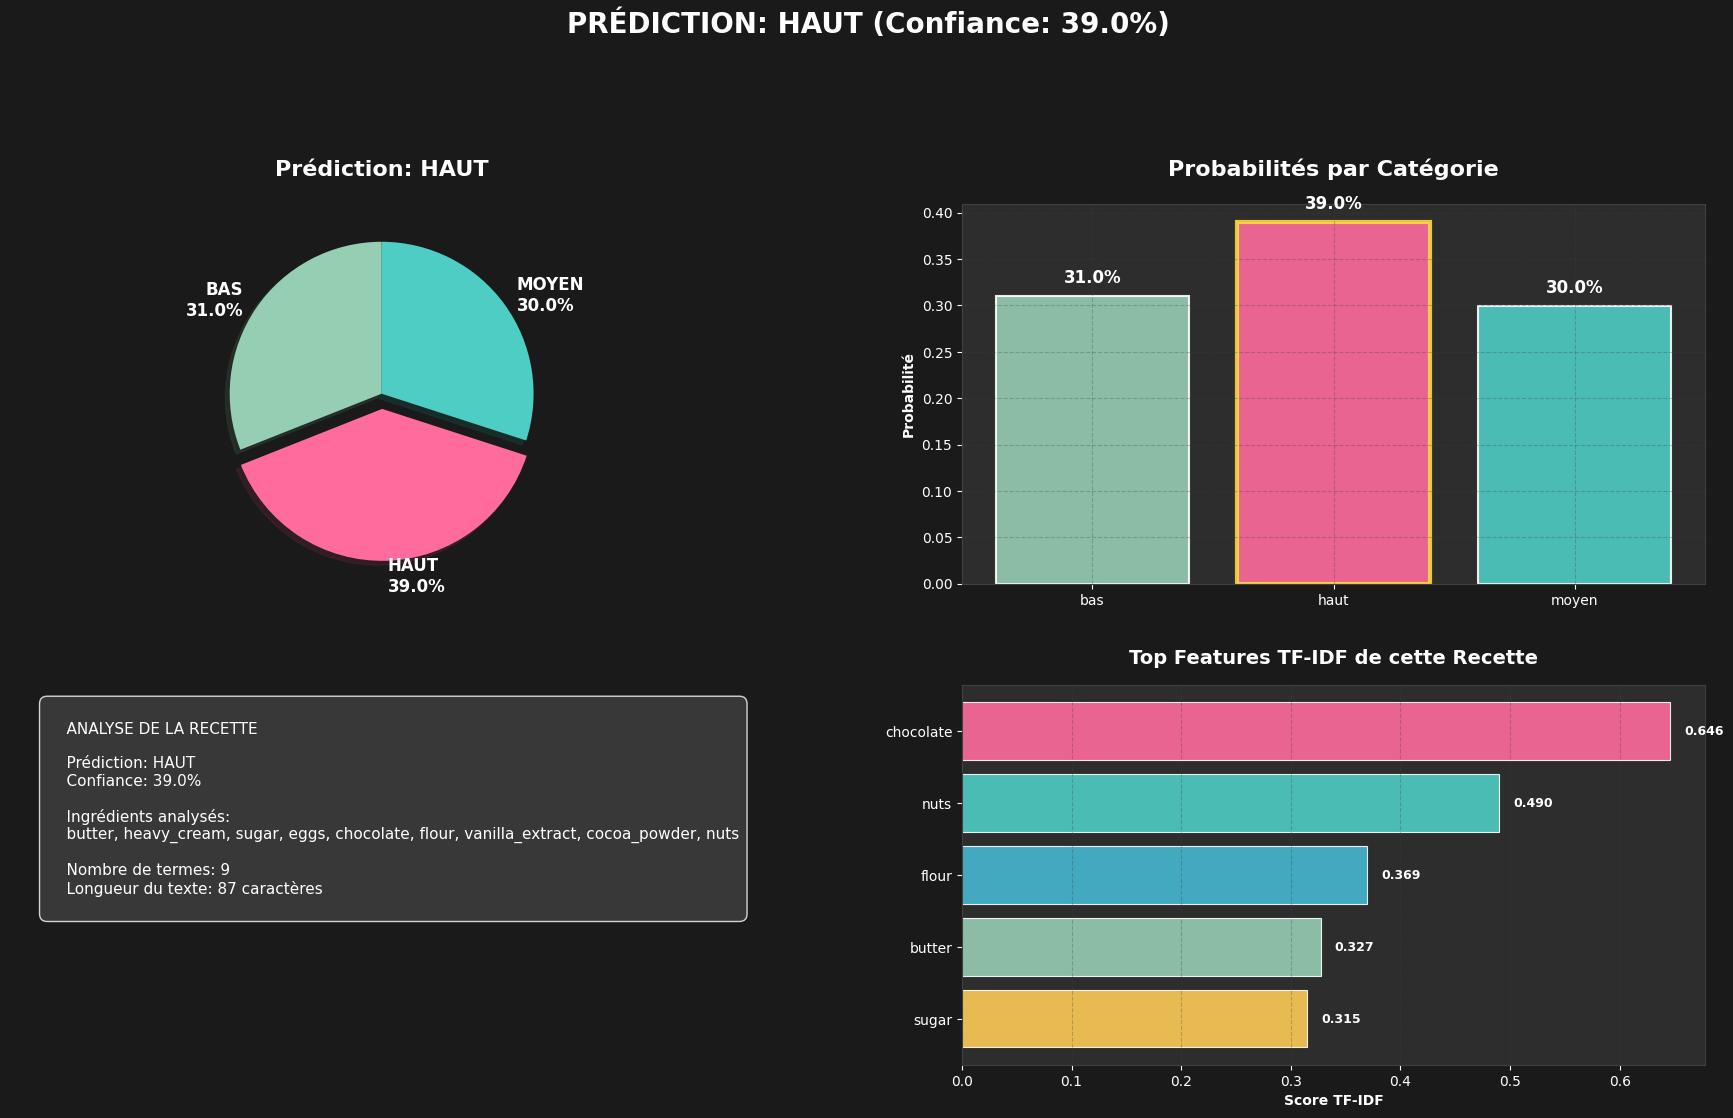

In [17]:
# Exemple avec un dessert riche
dessert_ingredients = "butter, heavy cream, sugar, eggs, chocolate, flour, vanilla extract, cocoa powder, nuts"
print(f"\nExemple 1 - Dessert riche:")
print(f"Ingrédients: {dessert_ingredients}")
pred1, prob1 = visualize_prediction(dessert_ingredients)

15.4. Test salade légère


Exemple 2 - Salade légère:
Ingrédients: lettuce, tomatoes, cucumber, onion, olive oil, vinegar, herbs, salt, pepper
Original: lettuce, tomatoes, cucumber, onion, olive oil, vinegar, herbs, salt, pepper
Cleaned: lettuce tomatoes cucumber onion olive_oil vinegar herbs salt pepper
Features numériques calculées:
- n_ingredients: 9
- Compteurs: fat=1, sugar=0, protein=0, vegetable=4
- Compteurs: grain=0, drink=0, spice=2
- Ratios: fat=0.111, sugar=0.000, protein=0.000

Dimensions finales:
- TF-IDF: (1, 300)
- Numériques: (1, 15)
- Combinées: (1, 315)
- Modèle attend: 315 features

Résultat:
- Prédiction: bas
- Confiance: 76.6%
- bas: 76.6%
- haut: 6.6%
- moyen: 16.7%


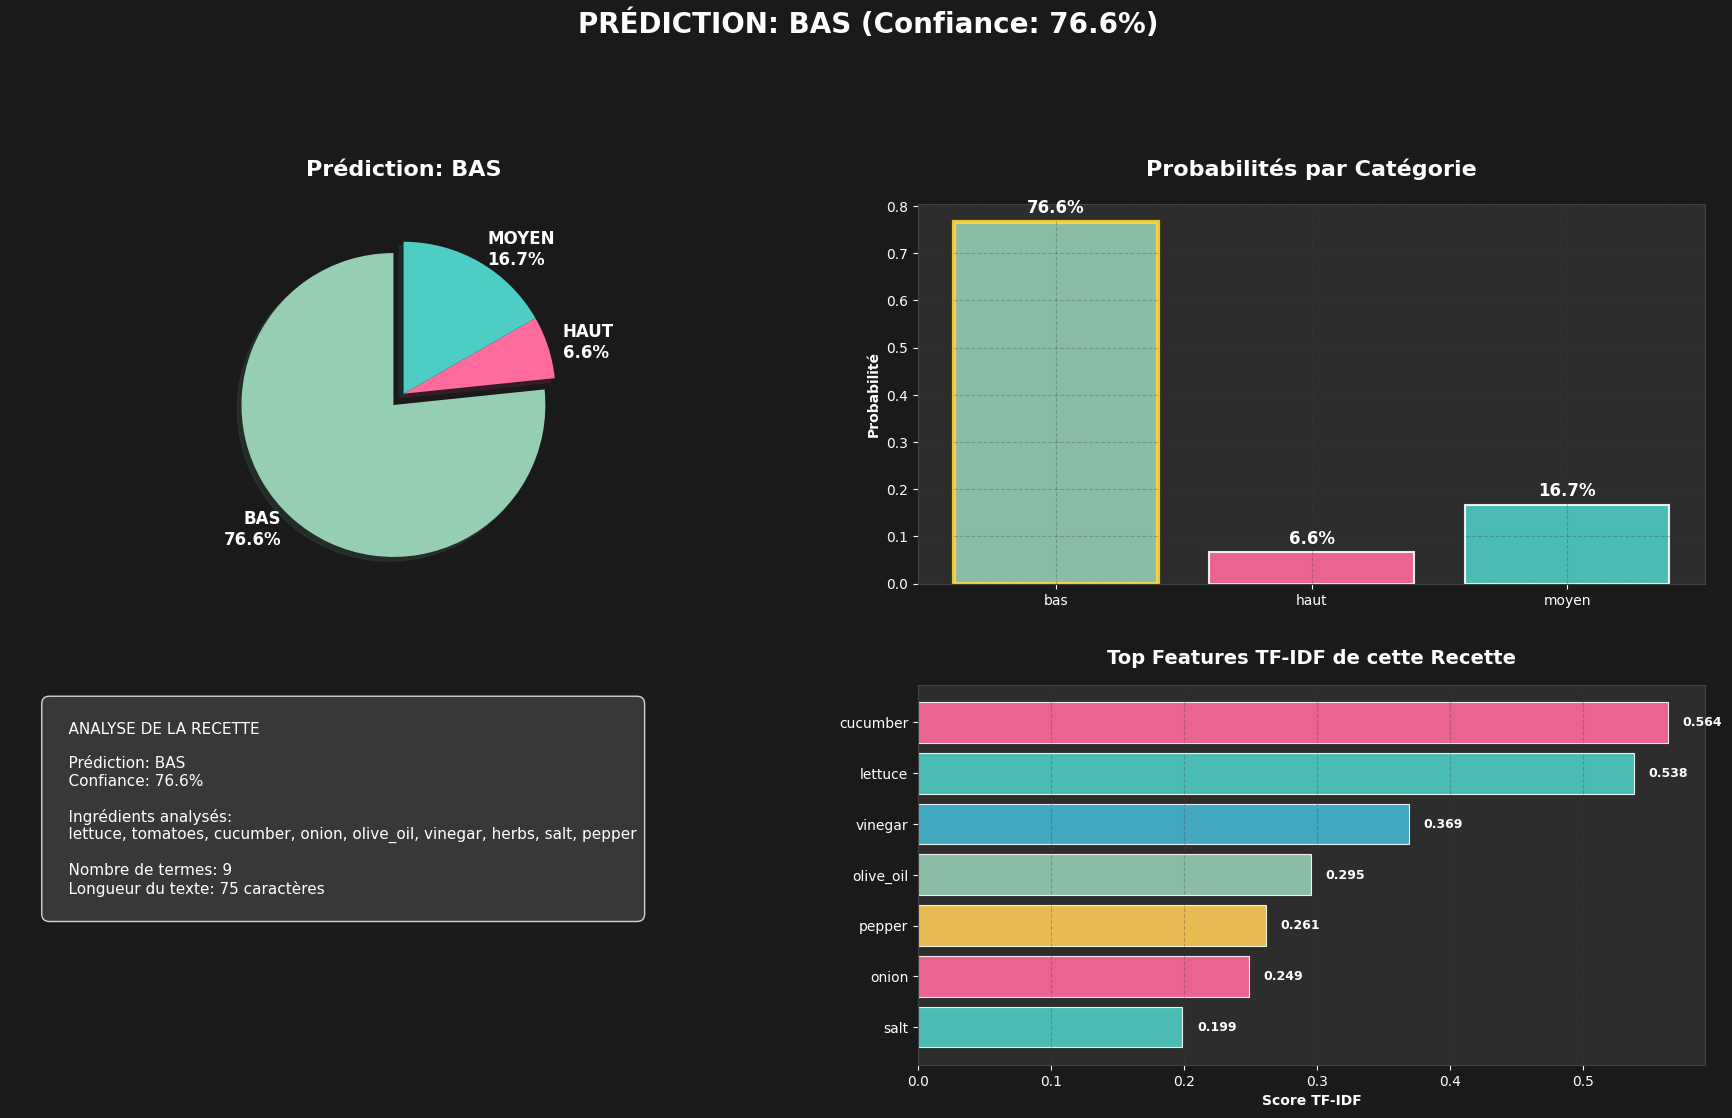

In [18]:
# Exemple avec une salade légère
salade_ingredients = "lettuce, tomatoes, cucumber, onion, olive oil, vinegar, herbs, salt, pepper"
print(f"\nExemple 2 - Salade légère:")
print(f"Ingrédients: {salade_ingredients}")
pred2, prob2 = visualize_prediction(salade_ingredients)


15.5. Test plat équilibré


Exemple 3 - Plat équilibré:
Ingrédients: chicken breast, rice, broccoli, carrots, olive oil, garlic, onion, soy sauce, herbs
Original: chicken breast, rice, broccoli, carrots, olive oil, garlic, onion, soy sauce, herbs
Cleaned: chicken_breast rice broccoli carrots olive_oil garlic onion soy_sauce herbs
Features numériques calculées:
- n_ingredients: 9
- Compteurs: fat=1, sugar=0, protein=1, vegetable=4
- Compteurs: grain=1, drink=1, spice=0
- Ratios: fat=0.111, sugar=0.000, protein=0.111

Dimensions finales:
- TF-IDF: (1, 300)
- Numériques: (1, 15)
- Combinées: (1, 315)
- Modèle attend: 315 features

Résultat:
- Prédiction: moyen
- Confiance: 42.5%
- bas: 17.5%
- haut: 40.0%
- moyen: 42.5%


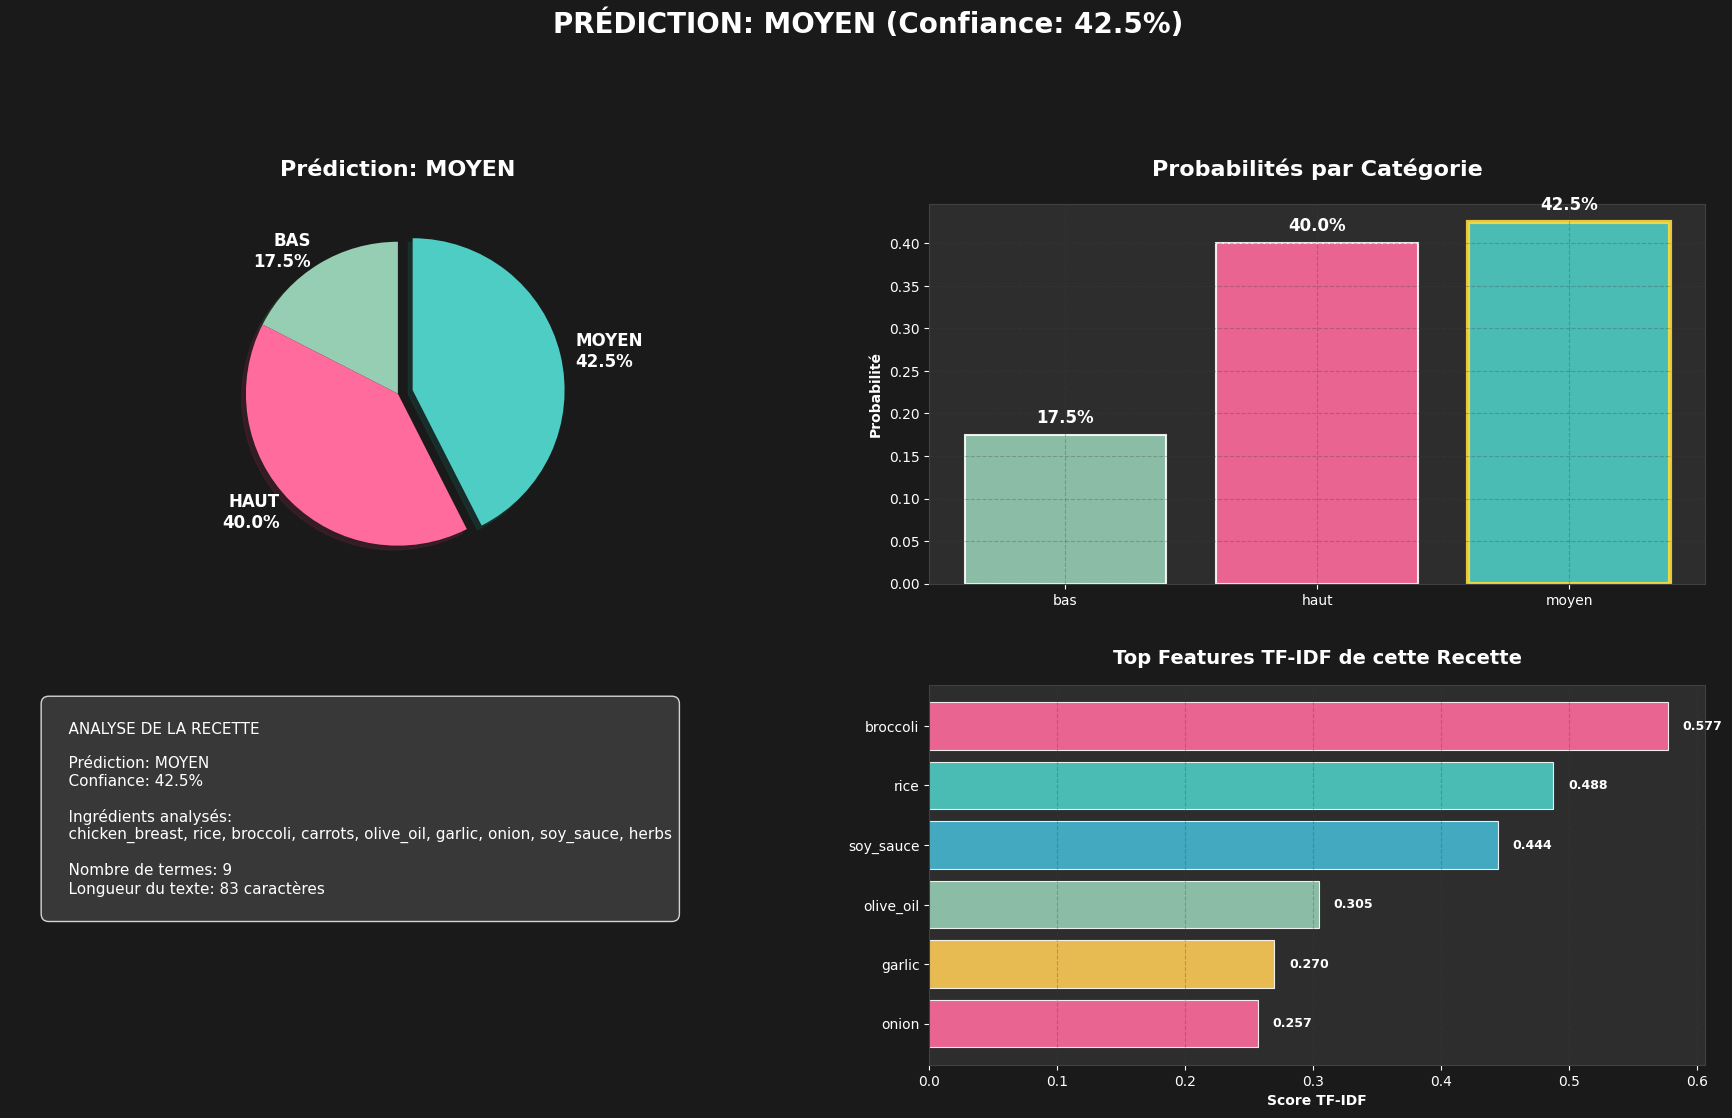

In [19]:
# Exemple avec un plat équilibré
plat_ingredients = "chicken breast, rice, broccoli, carrots, olive oil, garlic, onion, soy sauce, herbs"
print(f"\nExemple 3 - Plat équilibré:")
print(f"Ingrédients: {plat_ingredients}")
pred3, prob3 = visualize_prediction(plat_ingredients)

# 12. Sauvegarde du modèle

In [ ]:
import joblib

# Sauvegarder le modèle et le vectoriseur
joblib.dump(best_xgb, './models/calorie_prediction_model_v2.pkl')
joblib.dump(tfidf, './models/tfidf_vectorizer_v2.pkl')

print("Modèle et vectoriseur sauvegardés!")
print("- ./models/calorie_prediction_model_v2.pkl")
print("- ./models/tfidf_vectorizer_v2.pkl")

# Pour charger plus tard:
# loaded_model = joblib.load('./models/calorie_prediction_model_v2.pkl')
# loaded_tfidf = joblib.load('./models/tfidf_vectorizer_v2.pkl')

Modèle et vectoriseur sauvegardés!
- ./model/calorie_prediction_model.pkl
- ./model/tfidf_vectorizer.pkl


## 13. Résumé des résultats et conclusions

In [21]:
print("=" * 60)
print("RÉSUMÉ DU MODÈLE DE PRÉDICTION CALORIQUE HARMONISÉ")
print("=" * 60)
print(f"Dataset: {df.shape[0]:,} recettes")
print(f"Features: {X_combined.shape[1]:,} features TF-IDF")
print(f"Classes: {sorted(best_xgb.classes_)}")
print(f"\nPerformances:")
print(f"   Accuracy d'entraînement: {train_accuracy:.4f}")
print(f"   Accuracy de test: {test_accuracy:.4f}")
print(f"   Score de validation croisée: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\nMeilleurs hyperparamètres:")
for param, value in search_xgb_balanced.best_params_.items():
    print(f"   {param}: {value}")
print(f"\nTop 5 features les plus importantes:")
for i, (feature, importance) in enumerate(importance_df.head(5).values):
    print(f"   {i+1}. {feature}: {importance:.4f}")
print("=" * 60)

print("\nCONCLUSIONS PRINCIPALES:")
print("• Le modèle XGBoost peut prédire efficacement les niveaux caloriques")
print("• Les ingrédients riches (beurre, crème, sucre) sont de bons prédicteurs de calories élevées")
print("• L'analyse SHAP permet de comprendre les contributions de chaque feature")
print("• Le modèle peut être utilisé pour évaluer de nouvelles recettes")
print("• Les bonnes pratiques ML ont été appliquées (nettoyage, validation croisée, optimisation)")
print("• Fonction de prédiction interactive avec analyses détaillées")
print("=" * 60)

RÉSUMÉ DU MODÈLE DE PRÉDICTION CALORIQUE HARMONISÉ
Dataset: 228,430 recettes
Features: 315 features TF-IDF
Classes: [0, 1, 2]

Performances:
   Accuracy d'entraînement: 0.5896
   Accuracy de test: 0.5330
   Score de validation croisée: 0.5308 (+/- 0.0051)

Meilleurs hyperparamètres:
   subsample: 0.7
   reg_lambda: 1.2
   reg_alpha: 0.2
   n_estimators: 300
   min_child_weight: 5
   max_depth: 8
   learning_rate: 0.05
   gamma: 0.1
   colsample_bytree: 0.9

Top 5 features les plus importantes:
   1. nb_protein: 0.0398
   2. nb_fat: 0.0290
   3. pasta: 0.0184
   4. beef: 0.0131
   5. green_beans: 0.0101

CONCLUSIONS PRINCIPALES:
• Le modèle XGBoost peut prédire efficacement les niveaux caloriques
• Les ingrédients riches (beurre, crème, sucre) sont de bons prédicteurs de calories élevées
• L'analyse SHAP permet de comprendre les contributions de chaque feature
• Le modèle peut être utilisé pour évaluer de nouvelles recettes
• Les bonnes pratiques ML ont été appliquées (nettoyage, valida